In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import glob 
from functools import reduce
import re
import os
from collections import Counter
import scvi
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42

## Helpful locations which are assumed to already exist
work_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Yuanyuan/Project/BGa/results/fig4"
data_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/linking"
os.chdir(work_dir)

/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/

## Prepare/subset the Astro data from WB/published datasets

### (1) Siletti Human WB Astro - rna

In [2]:
siletti = sc.read_h5ad(data_dir + "/Siletti_astro_norm.h5ad")

In [3]:
siletti

AnnData object with n_obs × n_vars = 155025 × 59236
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'feature_label'
    uns: 'batch_condition', 'citation', 'log1p', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

In [4]:
type1_clusters = [52, 53, 54, 55, 56, 57, 58, 61]

siletti.obs['Type'] = siletti.obs['cluster_id'].apply(lambda x: 'Type1' if x in type1_clusters else 'Type2')
siletti.obs['Type'] = siletti.obs['Type'].astype('category')

In [5]:
print(set(siletti.obs['cluster_id']))

{64, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}


In [6]:
siletti.obs["cluster_id"] = siletti.obs["cluster_id"].astype(str)
desired_siletti_order = ["52", "53", "54", "55", "58", "57", "56", "60", "59", "62", "61", "64", "63"]

#siletti_meta = {
 #   "52": "Type1 TE (GM Cx)", 
 #   "53": "Type1 TE (GM HIP)",
 #   "54": "Type1 TE (GM Cx-HIP-AMY)",
 #   "55": "Type1 TE (GM Pu-CaB-SI)",
 #   "56": "Type1 TE (mix HTH-THM-AMY)",
 #   "57": "Type1 TE (mix HIP-BF)",
 #   "58": "Type1 TE (ILA Cx-HIP)",
 #   "61": "Type1 TE (WM HIP-Cx-BF)",
 #   "64": "Type2 NT (WM HTH)",
 #   "63": "Type2 NT (WM MY-SpC-Pn)",
 #   "62": "Type2 NT (mix GP-CB-M)",
 #   "60": "Type2 NT (GM THM-M-Pn)",
 #   "59": "Type2 NT (GM Pn-CB-MY)",
#}

siletti_meta = {
    "52": "TE (GM Cx)", 
    "53": "TE (GM HIP)",
    "54": "TE (GM Cx-HIP-AMY)",
    "55": "TE (GM Pu-CaB-SI)",
    "56": "TE (mixed HTH-THM-AMY)",
    "57": "TE (mixed HIP-BF)",
    "58": "TE (ILA Cx-HIP)",
    "61": "TE (WM HIP-Cx-BF)",
    "64": "NT (WM HTH)",
    "63": "NT (WM MY-SpC-Pn)",
    "62": "NT (mixed GP-CB-M)",
    "60": "NT (GM THM-M-Pn)",
    "59": "NT (GM Pn-CB-MY)",
}

siletti.obs["cluster_id_notes"] = siletti.obs["cluster_id"].map(lambda x: f"{x}: {siletti_meta[x]}")

categories_with_numbers = [f"{k}: {siletti_meta[k]}" for k in desired_siletti_order]
siletti.obs["cluster_id_notes"] = pd.Categorical(
    siletti.obs["cluster_id_notes"],
    categories=categories_with_numbers,
    ordered=True
)


In [7]:
genes = ['LHX2', 'ADGRV1', 'TNC', 'PAX6']
all_varnames = siletti.var_names
matched_genes = []
for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)

Matched gene IDs: ['LHX2_ENSG00000106689', 'ADGRV1_ENSG00000164199', 'TNC_ENSG00000041982', 'PAX6_ENSG00000007372']


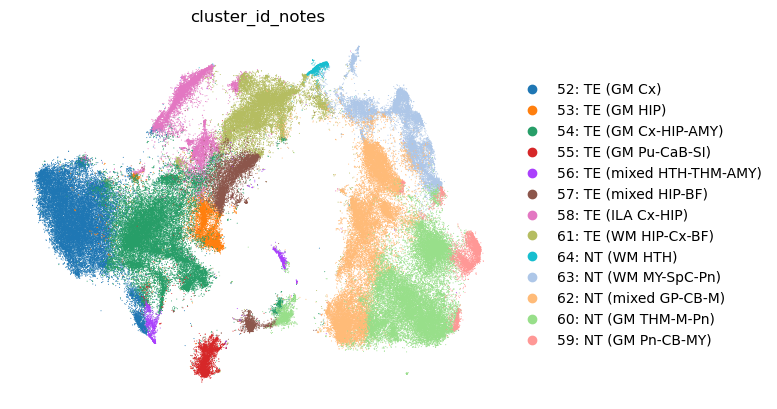

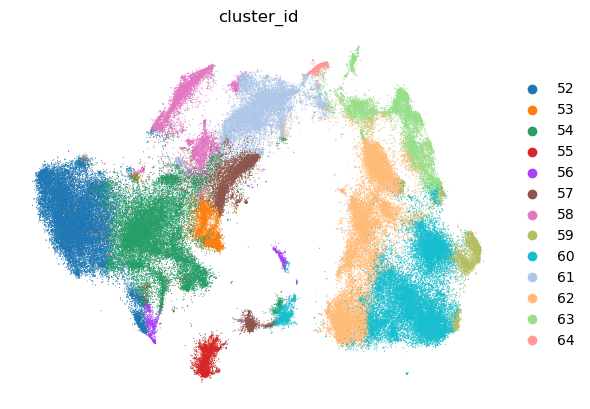

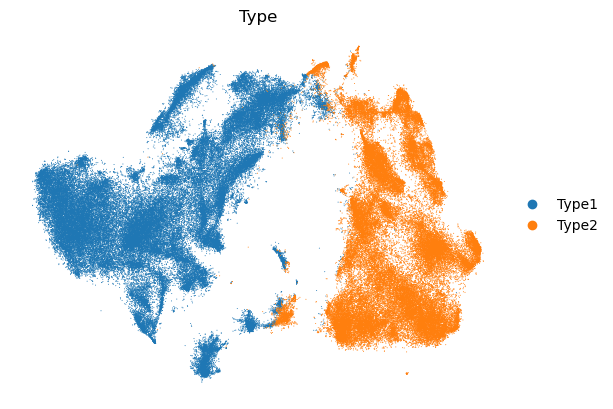

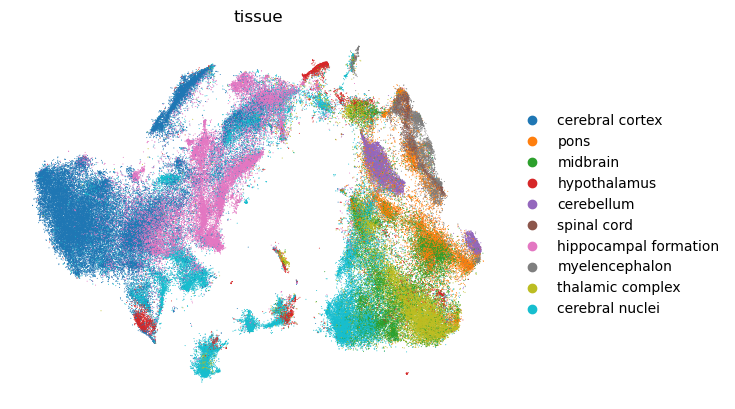

In [18]:
sc.pl.embedding(
    siletti,
    basis="X_tSNE",
    color=['cluster_id_notes'],#, 'LHX2_ENSG00000106689', 'ADGRV1_ENSG00000164199', 'GFAP_ENSG00000131095', 'PAX6_ENSG00000007372'],
    frameon=False,
    ncols=1,
    size=2,
    save="siletti_clusterIDs.pdf" 
)

sc.pl.embedding(
    siletti,
    basis="X_tSNE",
    color=['cluster_id'],#,
    frameon=False,
    ncols=1,
    size=2,
    save="siletti_clusterIDs_Withoutnotes.pdf" 
)

sc.pl.embedding(
    siletti,
    basis="X_tSNE",
    color=['Type'],#, 
    frameon=False,
    ncols=1,
    size=2,
    save="siletti_clusterIDs.pdf" 
)

sc.pl.embedding(
    siletti,
    basis="X_tSNE",
    color=['tissue'],
    frameon=False,
    ncols=1,
    size=2,
    save="siletti_tissue-dissection.pdf" 
)

Matched gene IDs: ['LHX2_ENSG00000106689', 'ADGRV1_ENSG00000164199', 'TNC_ENSG00000041982', 'FOXG1_ENSG00000176165', 'EMX1_ENSG00000135638', 'PAX6_ENSG00000007372', 'NFIA_ENSG00000162599', 'DMRTA2_ENSG00000142700', 'PAX6_ENSG00000007372']


[<Axes: title={'center': 'Type'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'cluster_id'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'tissue'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'LHX2_ENSG00000106689'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'ADGRV1_ENSG00000164199'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'TNC_ENSG00000041982'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'FOXG1_ENSG00000176165'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'EMX1_ENSG00000135638'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'PAX6_ENSG00000007372'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'NFIA_ENSG00000162599'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'DMRTA2_ENSG00000142700'}, xlabel='X_tSNE1', ylabel='X_tSNE2'>,
 <Axes: title={'center': 'PAX6_ENSG00000007372'}, xlabel='X_tSNE1', ylabel='X_t

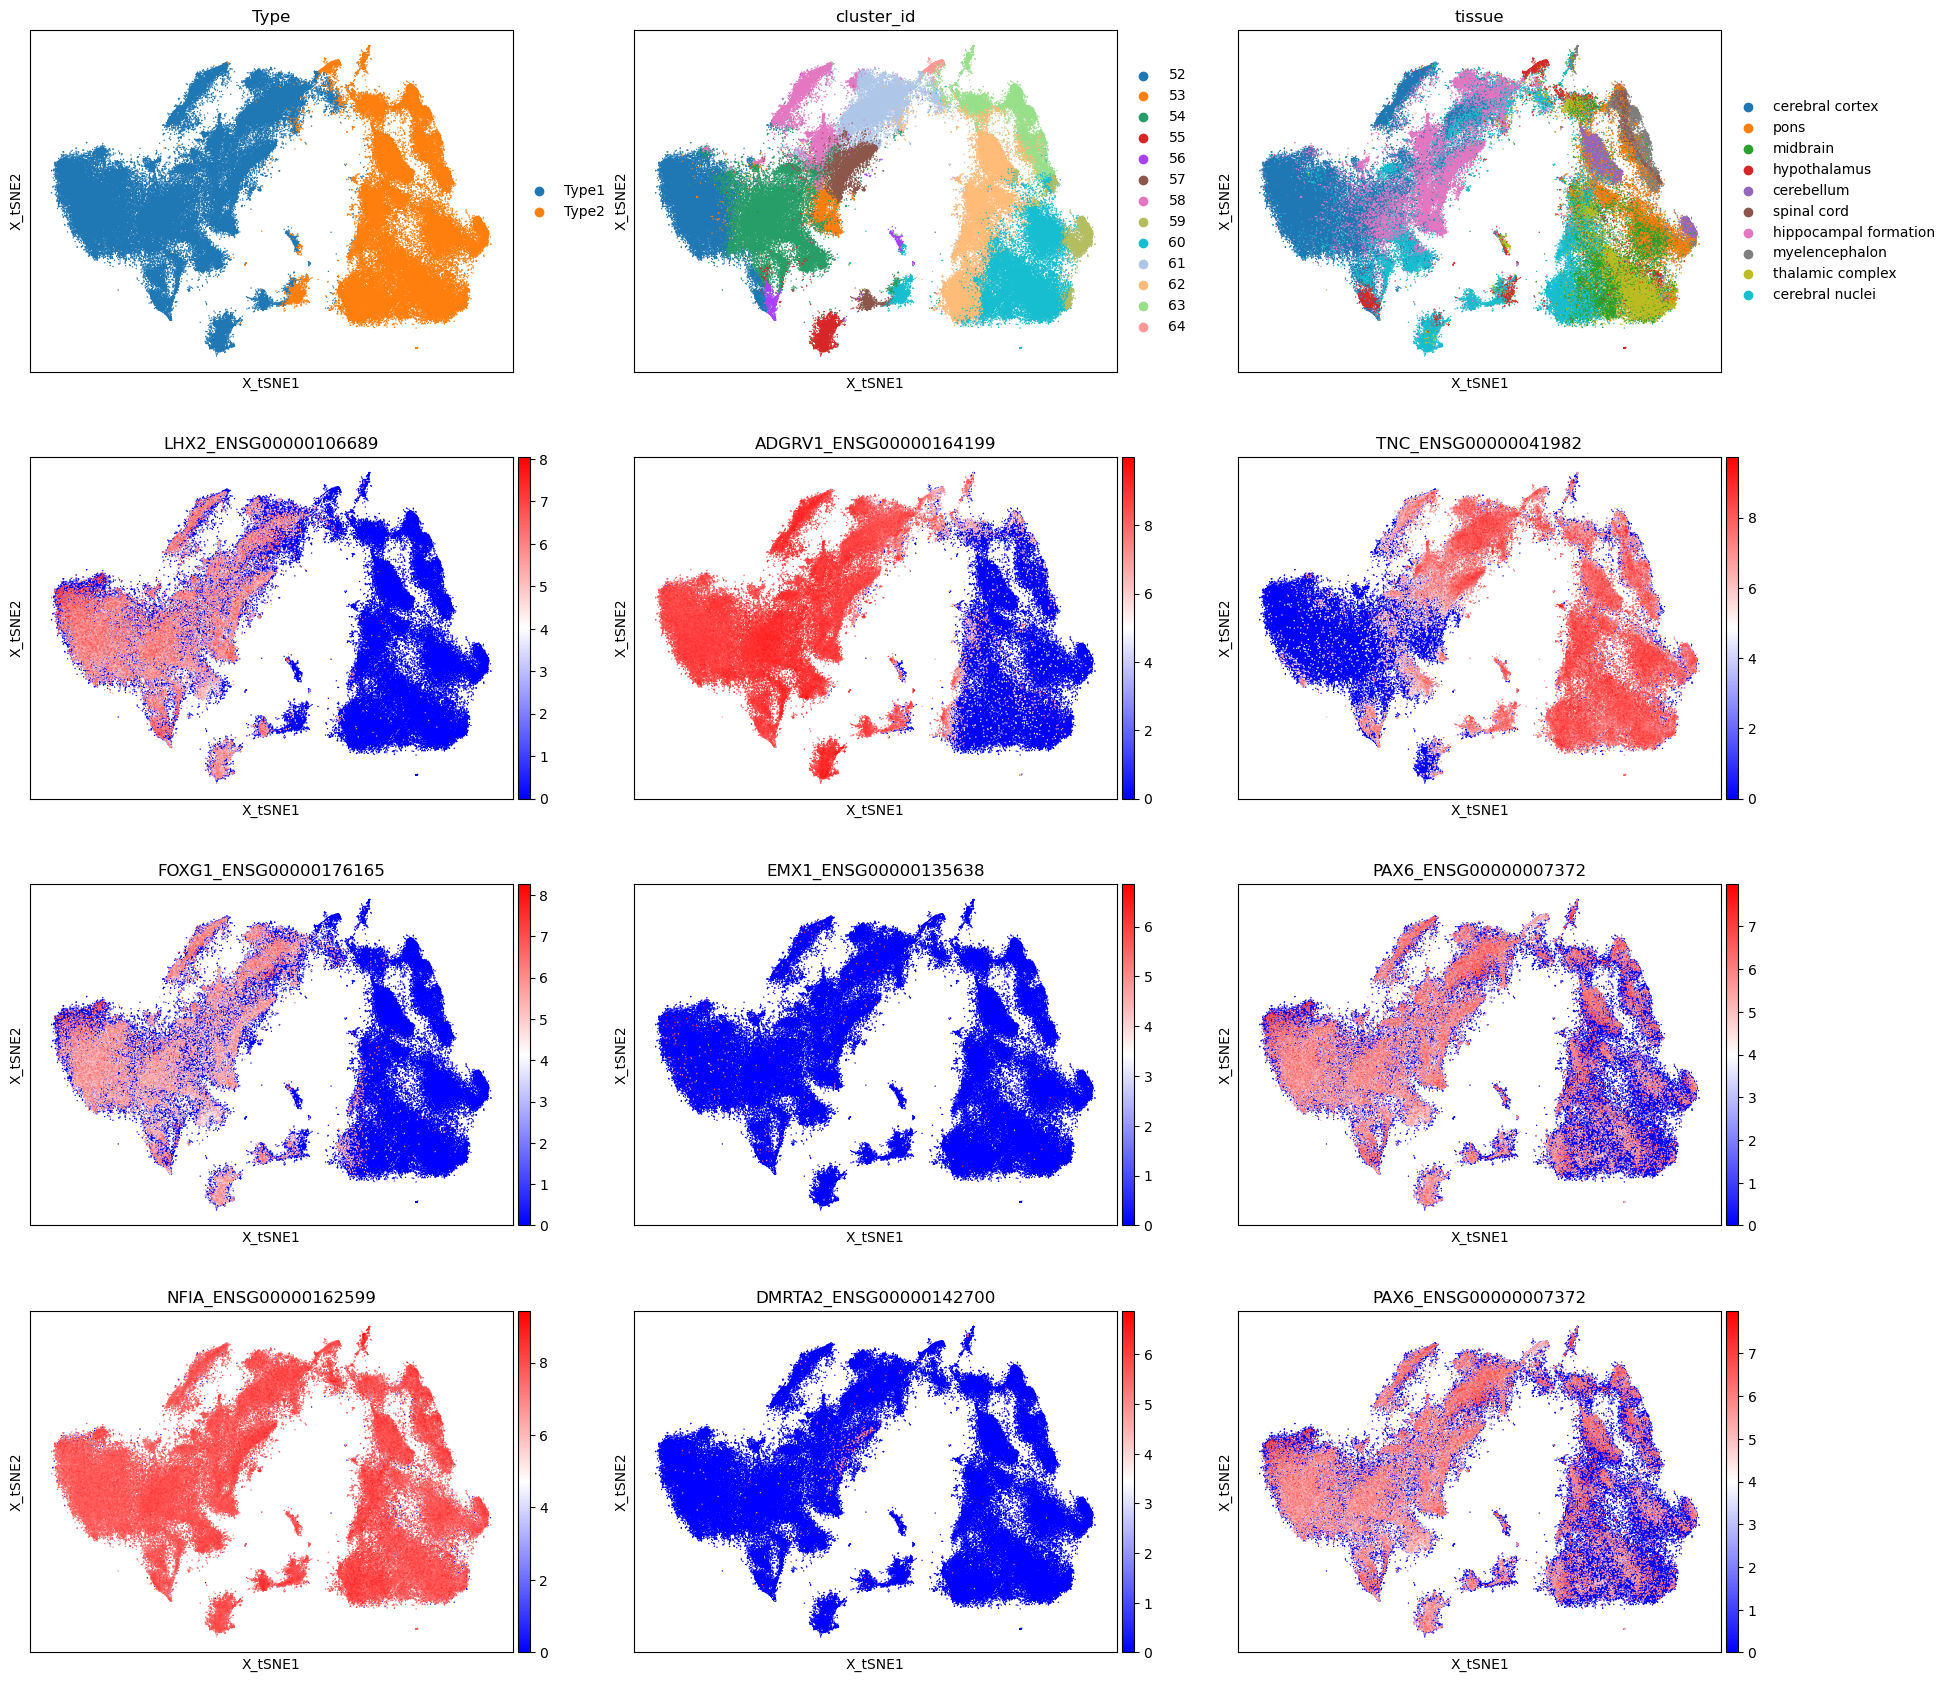

In [9]:
genes = ['LHX2', 'ADGRV1', 'TNC', 'FOXG1', 'EMX1', 'PAX6', 'NFIA', 'DMRTA2', 'PAX6']
all_varnames = siletti.var_names
matched_genes = []
for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)


sc.pl.embedding(
    siletti,
    basis="X_tSNE",
    size=4,
    color_map="bwr",
    color=["Type", "cluster_id", "tissue"] + matched_genes,
  #  palette={"Type1": "#1f78b4", "Type2": "lightgray"},
    show=False,
    ncols=3,
    use_raw=False,
)

Matched gene IDs: ['GRM3_ENSG00000198822', 'WIF1_ENSG00000156076', 'TMEM132C_ENSG00000181234', 'ADAMTS17_ENSG00000140470', 'CACNA1A_ENSG00000141837', 'OAF_ENSG00000184232', 'EPHA4_ENSG00000116106', 'FOXG1_ENSG00000176165', 'LHX2_ENSG00000106689', 'CSPG5_ENSG00000114646', 'EMX2_ENSG00000170370', 'TNC_ENSG00000041982', 'GFAP_ENSG00000131095', 'DPP6_ENSG00000130226', 'RGS6_ENSG00000182732', 'TSHZ2_ENSG00000182463', 'ADAMTSL3_ENSG00000156218', 'COL21A1_ENSG00000124749', 'SLC38A1_ENSG00000111371', 'CCDC85A_ENSG00000055813', 'KCNJ3_ENSG00000162989', 'GALNT15_ENSG00000131386', 'STXBP5L_ENSG00000145087', 'MAN1C1_ENSG00000117643', 'ANGPT1_ENSG00000154188', 'CPAMD8_ENSG00000160111', 'SLCO3A1_ENSG00000176463', 'SMAD9_ENSG00000120693', 'CREB5_ENSG00000146592', 'SLC6A11_ENSG00000132164', 'CDH23_ENSG00000107736', 'PTCH1_ENSG00000185920', 'GLUL_ENSG00000135821', 'DPP10_ENSG00000175497']


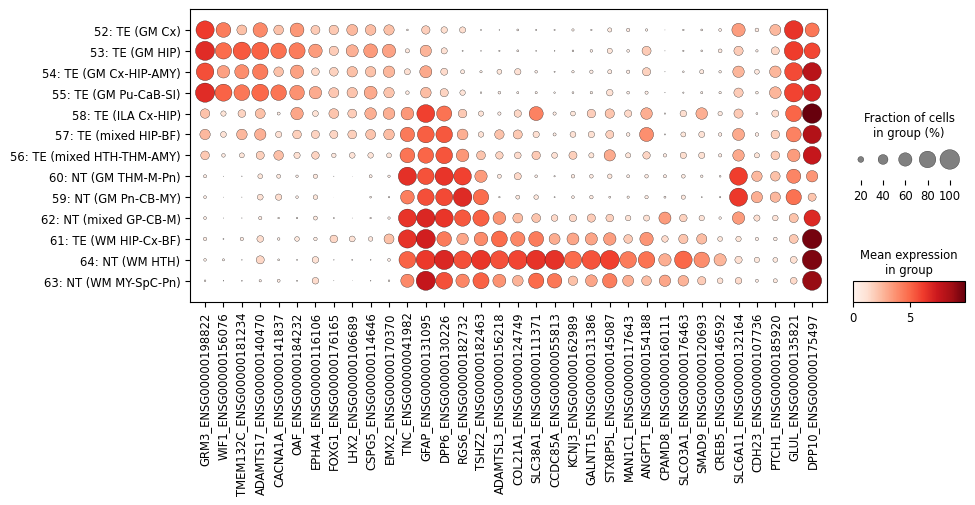

In [7]:
genes =['GRM3', 'WIF1', 'TMEM132C', 'ADAMTS17', 'CACNA1A', 'OAF', 'EPHA4','FOXG1', 'LHX2', 'CSPG5', 'EMX2', # GM STR; 'SLIT1', 
        'TNC', 'GFAP', 'DPP6', 'RGS6','TSHZ2', # GM exSTR + WM
        'ADAMTSL3', 'COL21A1', 'SLC38A1', 'CCDC85A', 'KCNJ3', 'GALNT15', 'STXBP5L', 'MAN1C1', 'ANGPT1','CPAMD8', 'SLCO3A1', 'SMAD9', 'CREB5', # WM; 'DCLK1', 
        'SLC6A11', 'CDH23',    # GM exSTR; 'PTPRJ', 'ADCY1',
        'PTCH1', 'GLUL',  # GM # 'SLC1A2', 'NRXN1', 'GPC5', 
        'DPP10', # GM STR + WM
          ] 

all_varnames = siletti.var_names
matched_genes = []
for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)


sc.pl.dotplot(
    siletti,
    var_names=matched_genes, 
    groupby="cluster_id_notes", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
    figsize=(10,3.8),
    save="dotplot_extendWB_markers.pdf"
)

Matched gene IDs: ['GRM3_ENSG00000198822', 'WIF1_ENSG00000156076', 'TMEM132C_ENSG00000181234', 'ADAMTS17_ENSG00000140470', 'CACNA1A_ENSG00000141837', 'OAF_ENSG00000184232', 'EPHA4_ENSG00000116106', 'FOXG1_ENSG00000176165', 'LHX2_ENSG00000106689', 'CSPG5_ENSG00000114646', 'EMX2_ENSG00000170370', 'TNC_ENSG00000041982', 'GFAP_ENSG00000131095', 'DPP6_ENSG00000130226', 'RGS6_ENSG00000182732', 'TSHZ2_ENSG00000182463', 'ADAMTSL3_ENSG00000156218', 'COL21A1_ENSG00000124749', 'SLC38A1_ENSG00000111371', 'CCDC85A_ENSG00000055813', 'KCNJ3_ENSG00000162989', 'GALNT15_ENSG00000131386', 'STXBP5L_ENSG00000145087', 'MAN1C1_ENSG00000117643', 'ANGPT1_ENSG00000154188', 'CPAMD8_ENSG00000160111', 'SLCO3A1_ENSG00000176463', 'SMAD9_ENSG00000120693', 'CREB5_ENSG00000146592', 'SLC6A11_ENSG00000132164', 'CDH23_ENSG00000107736', 'PTCH1_ENSG00000185920', 'GLUL_ENSG00000135821', 'DPP10_ENSG00000175497']


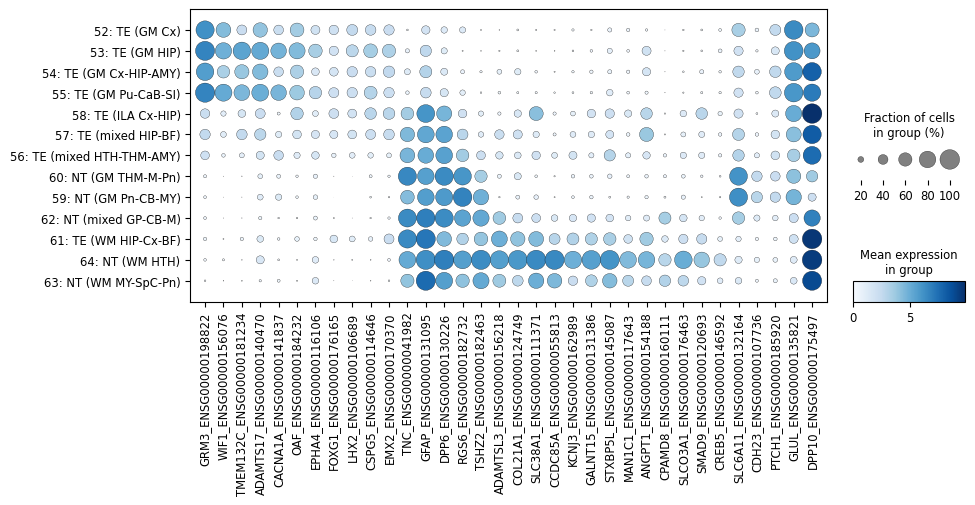

In [8]:
genes =['GRM3', 'WIF1', 'TMEM132C', 'ADAMTS17', 'CACNA1A', 'OAF', 'EPHA4','FOXG1', 'LHX2', 'CSPG5', 'EMX2', # GM STR; 'SLIT1', 
        'TNC', 'GFAP', 'DPP6', 'RGS6','TSHZ2', # GM exSTR + WM
        'ADAMTSL3', 'COL21A1', 'SLC38A1', 'CCDC85A', 'KCNJ3', 'GALNT15', 'STXBP5L', 'MAN1C1', 'ANGPT1','CPAMD8', 'SLCO3A1', 'SMAD9', 'CREB5', # WM; 'DCLK1', 
        'SLC6A11', 'CDH23',    # GM exSTR; 'PTPRJ', 'ADCY1',
        'PTCH1', 'GLUL',  # GM # 'SLC1A2', 'NRXN1', 'GPC5', 
        'DPP10', # GM STR + WM
          ] 

all_varnames = siletti.var_names
matched_genes = []
for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)


sc.pl.dotplot(
    siletti,
    var_names=matched_genes, 
    groupby="cluster_id_notes", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
    figsize=(10,3.8),
    cmap='Blues',
    save="dotplot_extendWB_markers_Blues.pdf"
)

Matched gene IDs: ['NFIA_ENSG00000162599', 'SLC1A2_ENSG00000110436', 'LHX2_ENSG00000106689', 'EPHA6_ENSG00000080224', 'ADAMTS17_ENSG00000140470', 'TMEM132C_ENSG00000181234', 'GRM3_ENSG00000198822', 'WIF1_ENSG00000156076', 'TNC_ENSG00000041982', 'RGS6_ENSG00000182732', 'JUN_ENSG00000177606', 'JUNB_ENSG00000171223', 'FOS_ENSG00000170345', 'ADAMTSL3_ENSG00000156218', 'CCDC85A_ENSG00000055813', 'SLC6A11_ENSG00000132164', 'GLUL_ENSG00000135821']


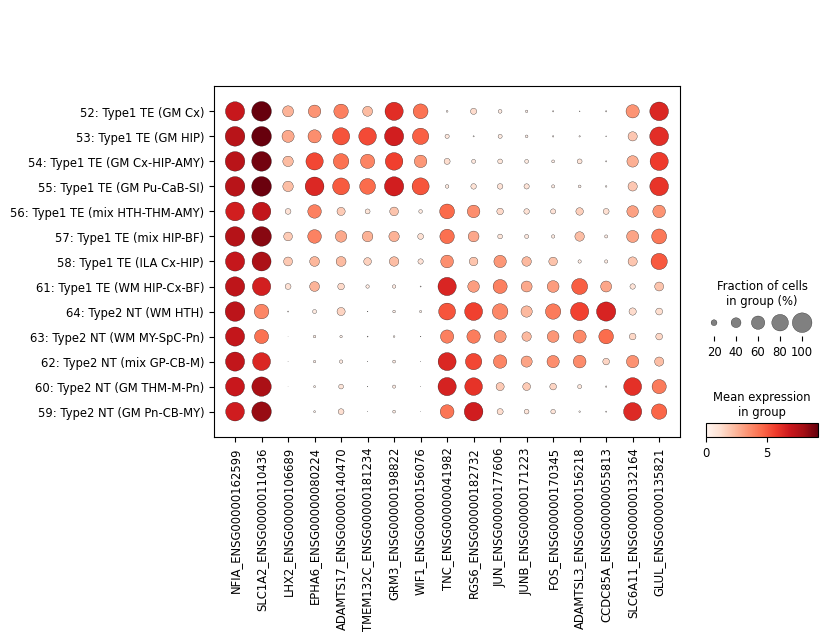

In [58]:
genes = ['NFIA', 'SLC1A2', 'LHX2', 'EPHA6', 'ADAMTS17', 'TMEM132C', 'GRM3', 'WIF1', 'TNC', 'RGS6', 'JUN', 'JUNB', 'FOS', 'ADAMTSL3', 'CCDC85A', 'SLC6A11',  'GLUL',  ] #'ADGRV1','AQP4',


all_varnames = siletti.var_names
matched_genes = []
for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)


sc.pl.dotplot(
    siletti,
    var_names=matched_genes, 
    groupby="cluster_id_notes", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

Matched gene IDs: ['NFIA_ENSG00000162599', 'RFX3_ENSG00000080298', 'RFX4_ENSG00000111783', 'SLC1A2_ENSG00000110436', 'LHX2_ENSG00000106689', 'EPHA6_ENSG00000080224', 'ADAMTS17_ENSG00000140470', 'TMEM132C_ENSG00000181234', 'GRM3_ENSG00000198822', 'WIF1_ENSG00000156076', 'TNC_ENSG00000041982', 'RGS6_ENSG00000182732', 'JUN_ENSG00000177606', 'JUNB_ENSG00000171223', 'FOS_ENSG00000170345', 'ADAMTSL3_ENSG00000156218', 'CCDC85A_ENSG00000055813', 'SLC6A11_ENSG00000132164', 'GLUL_ENSG00000135821']


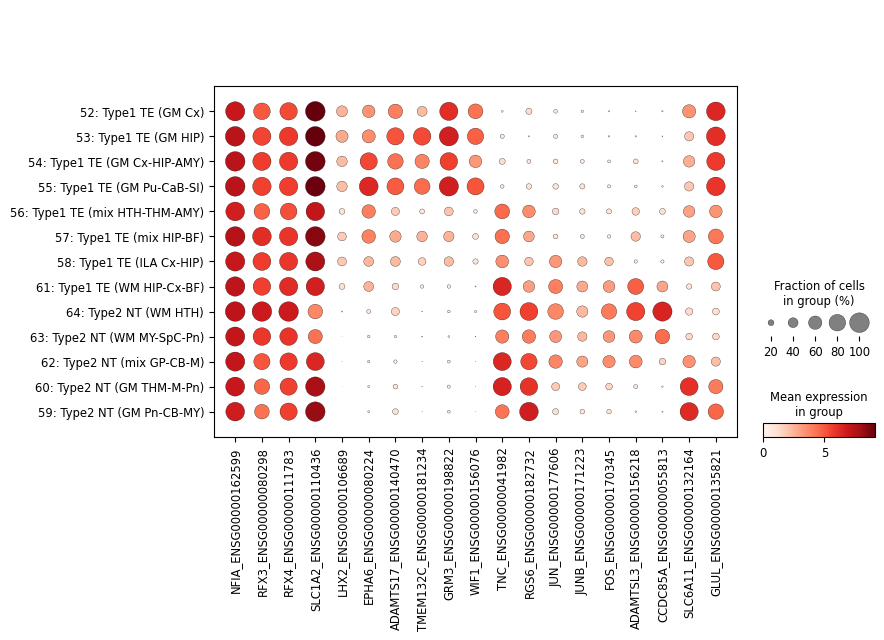

In [7]:
genes = ['NFIA', 'RFX3', 'RFX4', 'SLC1A2', 'LHX2', 'EPHA6', 'ADAMTS17', 'TMEM132C', 'GRM3', 'WIF1', 'TNC', 'RGS6', 'JUN', 'JUNB', 'FOS', 'ADAMTSL3', 'CCDC85A', 'SLC6A11',  'GLUL',  ] #'ADGRV1','AQP4',


all_varnames = siletti.var_names
matched_genes = []
for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)


sc.pl.dotplot(
    siletti,
    var_names=matched_genes, 
    groupby="cluster_id_notes", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

#### integration of HMBA human astro with Siletti astro

In [11]:
astro_inte = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/Human/BasalGanglia/backup/further_NN/Human_Astro_siletti_hmba_StudyIntegration_3kHVG_36latent_noImAstro_DonorStudy.h5ad")

In [12]:
astro_inte

AnnData object with n_obs × n_vars = 291709 × 35230
    obs: 'organism', 'donor_id', 'sex', 'age', 'cluster_id', 'subcluster_id', 'merged_ROIs', 'roi', 'ROI', 'total_genes', 'total_counts', 'sample_id', 'Group', 'batch_study', 'donor_study', 'leiden_scVI'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'gene_id', 'gene_name', 'feature', 'chromosome', 'start', 'stop', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden_scVI', 'log1p', 'neighbors', 'umap'
    obsm: 'X_UMAP', 'X_scVI', 'X_scVI_xStudies', 'X_tSNE', 'X_umap', 'X_umap_xStudies_scVIintegration'
    layers: 'UMIs'
    obsp: 'connectivities', 'distances'

[<Axes: title={'center': 'donor_id'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'batch_study'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'donor_study'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'cluster_id'}, xlabel='X_umap1', ylabel='X_umap2'>]

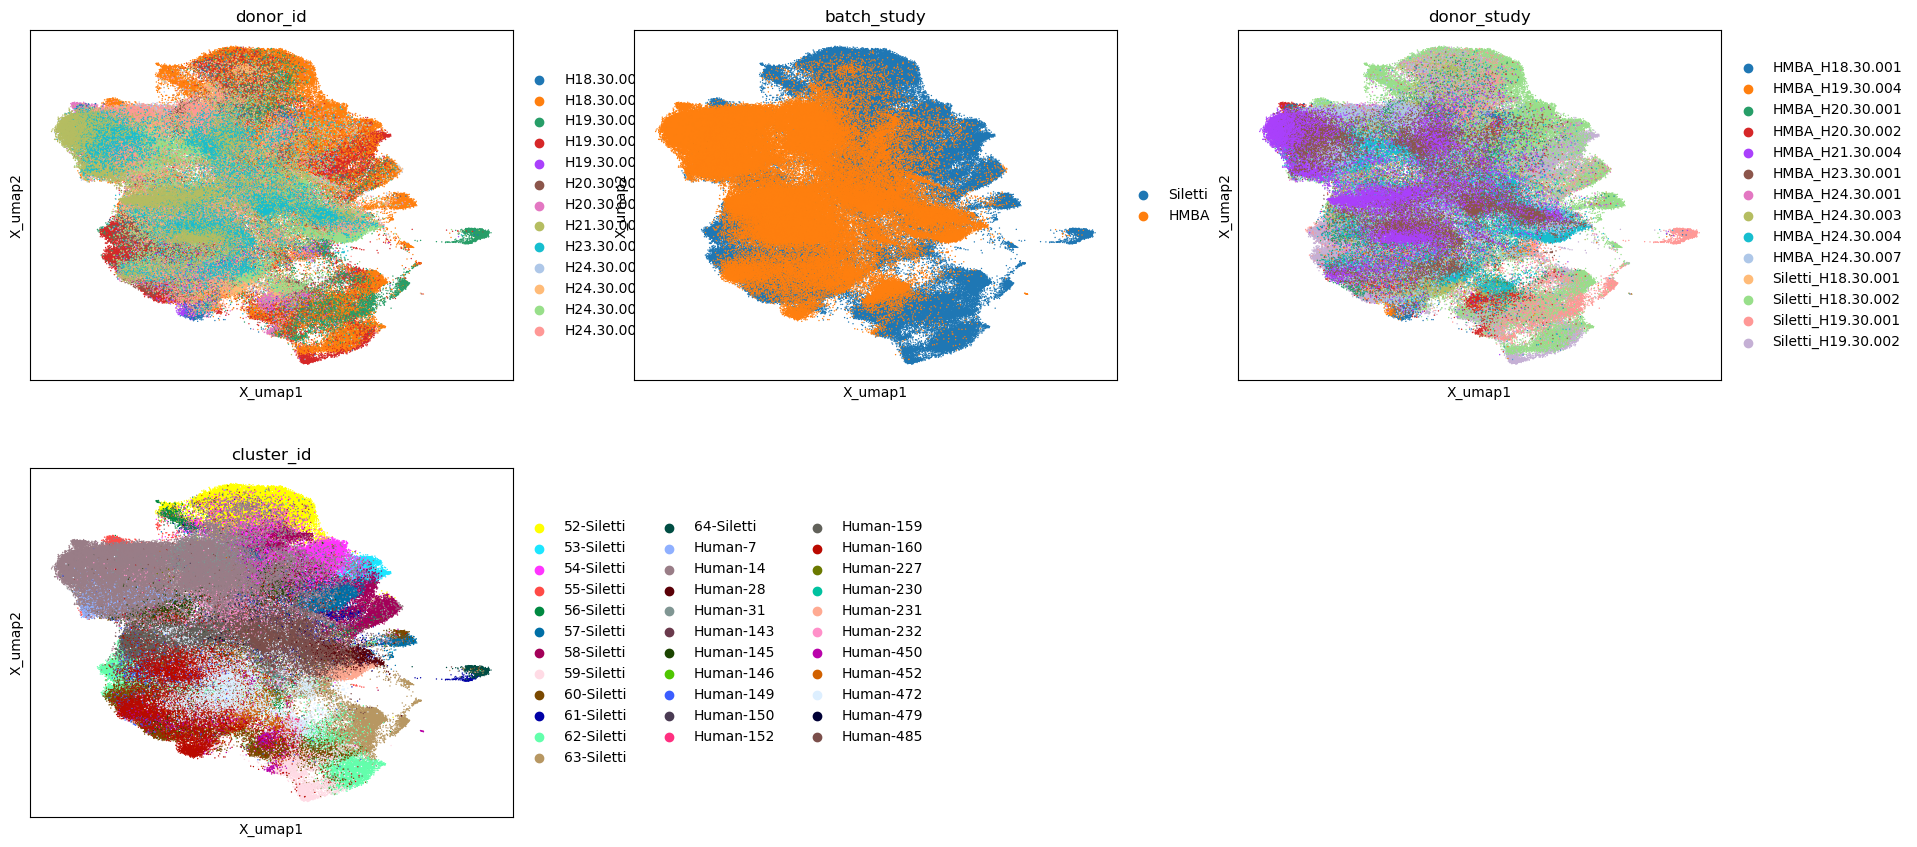

In [18]:
sc.pl.embedding(
    astro_inte,
    basis="X_umap", #"X_umap_xStudies_scVIintegration",
    size=4,
    color_map="bwr",
    color=["donor_id", "batch_study", "donor_study", "cluster_id"],
    show=False,
    ncols=3,
    use_raw=False,
)

#### mapping our Human BG to Siletti to get the Siletti lables

In [20]:
adata = sc.read_h5ad(data_dir + "/../HMBA_human_Astro_obs_Notes.h5ad")

### (2) Mouse ABC atlas Astro - rna

In [ ]:
# MouseABC_astro.ipynb

In [29]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/Human/BasalGanglia/analysis/data_input/mouseABC/AIT21_10Xv2v3.norm.30Astro-Epen.class.h5ad")
adata

AnnData object with n_obs × n_vars = 308681 × 32285
    obs: 'library_prep', 'gene.counts.0', 'doublet_score', 'roi', 'umi.counts', 'method', 'sex', 'external_donor_name', 'age', 'medical_conditions', 'cl', 'region_label', 'cluster_id', 'cluster_id_label', 'supertype_id', 'supertype_label', 'supertype_id_label', 'subclass_id', 'subclass_label', 'subclass_id_label', 'class_id', 'class_label', 'class_id_label', 'neighborhood7', '10x_platform'
    uns: 'log1p', 'region_label_colors', 'roi_colors'
    obsm: 'X_EMBED2', 'X_EMBED3'
    layers: 'UMIs'

In [30]:
set(adata.obs['subclass_id_label'])

{'316 Bergmann NN',
 '317 Astro-CB NN',
 '318 Astro-NT NN',
 '319 Astro-TE NN',
 '320 Astro-OLF NN',
 '321 Astroependymal NN',
 '322 Tanycyte NN',
 '323 Ependymal NN',
 '324 Hypendymal NN',
 '325 CHOR NN'}

In [31]:
adata = adata[adata.obs['subclass_id_label'].isin([ "316 Bergmann NN", "317 Astro-CB NN", "318 Astro-NT NN", "319 Astro-TE NN", "320 Astro-OLF NN"])].copy()
print(set(adata.obs['subclass_id_label'])) # 5 subclasses

{'320 Astro-OLF NN', '317 Astro-CB NN', '318 Astro-NT NN', '316 Bergmann NN', '319 Astro-TE NN'}


In [32]:
order1 = [
    "319 Astro-TE NN",
    "320 Astro-OLF NN",
    "318 Astro-NT NN",
    "317 Astro-CB NN",
    "316 Bergmann NN"
]
adata.obs['subclass_id_label'] = pd.Categorical(
    adata.obs['subclass_id_label'],
    categories=order1,
    ordered=True
)

order2 = [
    '1161 Astro-TE NN_1',
    '1162 Astro-TE NN_2',
    '1163 Astro-TE NN_3',
    '1164 Astro-TE NN_4',
    '1165 Astro-TE NN_5',
    '1166 Astro-OLF NN_1',
    '1167 Astro-OLF NN_2',
    '1168 Astro-OLF NN_3',
    '1159 Astro-NT NN_1',
    '1160 Astro-NT NN_2',
    '1158 Astro-CB NN_1',
    '1157 Bergmann NN_1',
]
adata.obs['supertype_id_label'] = pd.Categorical(
    adata.obs['supertype_id_label'],
    categories=order2,
    ordered=True
)


order3 = [
    '5218 Astro-TE NN_1',
    '5219 Astro-TE NN_1',
    '5220 Astro-TE NN_1',
    '5221 Astro-TE NN_1',
    '5222 Astro-TE NN_2',
    '5223 Astro-TE NN_2',
    '5224 Astro-TE NN_3',
    '5225 Astro-TE NN_3',
    '5226 Astro-TE NN_3',
    '5227 Astro-TE NN_3',
    '5228 Astro-TE NN_4',
    '5229 Astro-TE NN_5',
    '5230 Astro-TE NN_5',
    '5231 Astro-OLF NN_1',
    '5232 Astro-OLF NN_1',
    '5233 Astro-OLF NN_2',
    '5234 Astro-OLF NN_2',
    '5235 Astro-OLF NN_3',
    '5236 Astro-OLF NN_3',
    '5208 Astro-NT NN_1',
    '5209 Astro-NT NN_1',
    '5210 Astro-NT NN_1',
    '5211 Astro-NT NN_1',
    '5212 Astro-NT NN_1',
    '5213 Astro-NT NN_1',
    '5214 Astro-NT NN_2',
    '5215 Astro-NT NN_2',
    '5216 Astro-NT NN_2',
    '5217 Astro-NT NN_2',
    '5207 Astro-CB NN_1',
    '5206 Bergmann NN_1',
]
adata.obs['cluster_id_label'] = pd.Categorical(
    adata.obs['cluster_id_label'],
    categories=order3,
    ordered=True
)

In [ ]:

#print(set(adata.obs['supertype_id_label'])) # 11 supertypes
#print(set(adata.obs['cluster_id_label'])) # 30 clusters # 1 CB cluster, 6 OLF clusters.

#adata = adata[adata.obs['subclass_id_label'].isin(["318 Astro-NT NN", "319 Astro-TE NN"])] # "317 Astro-CB NN", "320 Astro-OLF NN"
#print(set(adata.obs['subclass_id_label'])) # 2 subclasses
#print(set(adata.obs['supertype_id_label'])) # 7 supertypes = 2 NT + 5 TE
#print(set(adata.obs['cluster_id_label'])) # 23 clusters 


In [ ]:
## cluster_id_label #anatomical_annotation (Yao et al, 2023 Nature - Supp_Table 7)

 # '5208 Astro-NT NN_1',  HB CB pia (drop)
 # '5209 Astro-NT NN_1',  MB HB pia (keep)
 # '5210 Astro-NT NN_1',  non-TE pia ventricle (keep) #no cells from our human BG mapped against this cluster. -> then, drop.
 # '5211 Astro-NT NN_1',  pia ve scattered (drop)
 # '5212 Astro-NT NN_1',  MB HB pia; ILA (keep)
 # '5213 Astro-NT NN_1',  DCO; ILA (drop - hindbrain_medulla) #many WM clusters mapped against this...
 # '5214 Astro-NT NN_2',  PAL TH HY MB (keep) ~ our exSTRd?
 # '5215 Astro-NT NN_2',  TH (keep for now) ~ STH like?
 # '5216 Astro-NT NN_2',  MY P MB (keep for now)
 # '5217 Astro-NT NN_2',  CBN VCO DCO (drop - CB and hindbrain only)
 # '5218 Astro-TE NN_1',  CTX pia sparse (drop - only CTX pia and sparse)
 # '5219 Astro-TE NN_1',  pia and fiber tract & may clean up more (keep - TE ILA; also highlighted in paper)
 # '5220 Astro-TE NN_1',  CTX pia sparse (drop)
 # '5221 Astro-TE NN_1',  CTX pia sparse (drop)
 # '5222 Astro-TE NN_2',  DG RGL-like(keep as contrast so that we cover all the supertypes)
 # '5223 Astro-TE NN_2',  DG cycling(drop -HIP)
 # '5224 Astro-TE NN_3',  enriched in LSX, HIP, DP-TT & may clean up more (drop)
 # '5225 Astro-TE NN_3',  Isocortex, OLF (keep as CTX GM contrast)
 # '5226 Astro-TE NN_3',  LSX and midline (keep - LSX belongs to STR in mice)
 # '5227 Astro-TE NN_3',  STRd (keep)
 # '5228 Astro-TE NN_4',  HIP/CTXsp (keep as contrast)
 # '5229 Astro-TE NN_5',  SVZ STRd AON (keep) RMS
 # '5230 Astro-TE NN_5'   SVZ STRd me;SVZ RGL-like (keep) RMS

In [33]:
set(adata.obs['cluster_id_label'])

{'5206 Bergmann NN_1',
 '5207 Astro-CB NN_1',
 '5208 Astro-NT NN_1',
 '5209 Astro-NT NN_1',
 '5210 Astro-NT NN_1',
 '5211 Astro-NT NN_1',
 '5212 Astro-NT NN_1',
 '5213 Astro-NT NN_1',
 '5214 Astro-NT NN_2',
 '5215 Astro-NT NN_2',
 '5216 Astro-NT NN_2',
 '5217 Astro-NT NN_2',
 '5218 Astro-TE NN_1',
 '5219 Astro-TE NN_1',
 '5220 Astro-TE NN_1',
 '5221 Astro-TE NN_1',
 '5222 Astro-TE NN_2',
 '5223 Astro-TE NN_2',
 '5224 Astro-TE NN_3',
 '5225 Astro-TE NN_3',
 '5226 Astro-TE NN_3',
 '5227 Astro-TE NN_3',
 '5228 Astro-TE NN_4',
 '5229 Astro-TE NN_5',
 '5230 Astro-TE NN_5',
 '5231 Astro-OLF NN_1',
 '5232 Astro-OLF NN_1',
 '5233 Astro-OLF NN_2',
 '5234 Astro-OLF NN_2',
 '5235 Astro-OLF NN_3',
 '5236 Astro-OLF NN_3'}

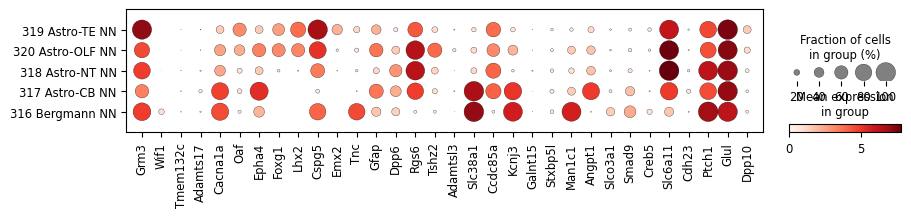

In [38]:
genes =['Grm3', 'Wif1', 'Tmem132c', 'Adamts17', 'Cacna1a', 'Oaf', 'Epha4','Foxg1', 'Lhx2', 'Cspg5', 'Emx2', # GM STR; 'SLIT1', 
        'Tnc', 'Gfap', 'Dpp6', 'Rgs6','Tshz2', # GM exSTR + WM
        'Adamtsl3',  'Slc38a1', 'Ccdc85a', 'Kcnj3', 'Galnt15', 'Stxbp5l', 'Man1c1', 'Angpt1', 'Slco3a1', 'Smad9', 'Creb5', # WM; 'DCLK1', 'Col21a1','Cpamd8',
        'Slc6a11', 'Cdh23',    # GM exSTR; 'PTPRJ', 'ADCY1',
        'Ptch1', 'Glul',  # GM # 'SLC1A2', 'NRXN1', 'GPC5', 
        'Dpp10', # GM STR + WM
        ] 


sc.pl.dotplot(
    adata,
    var_names=genes, 
    groupby="subclass_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
    figsize=(10,1.6),
    save="mouse_markers_subclass.pdf"
)


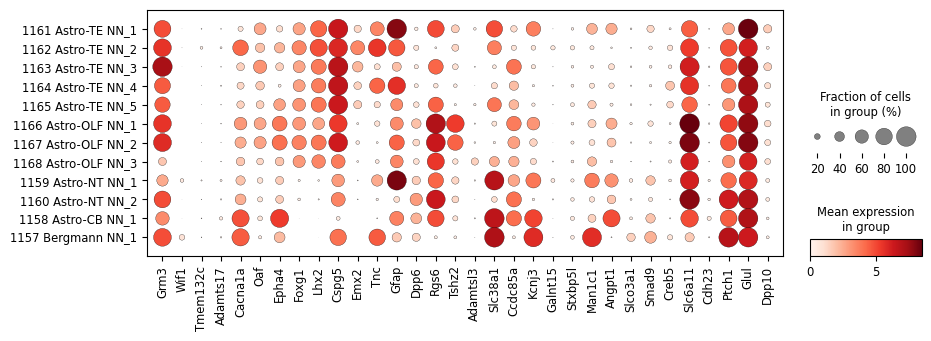

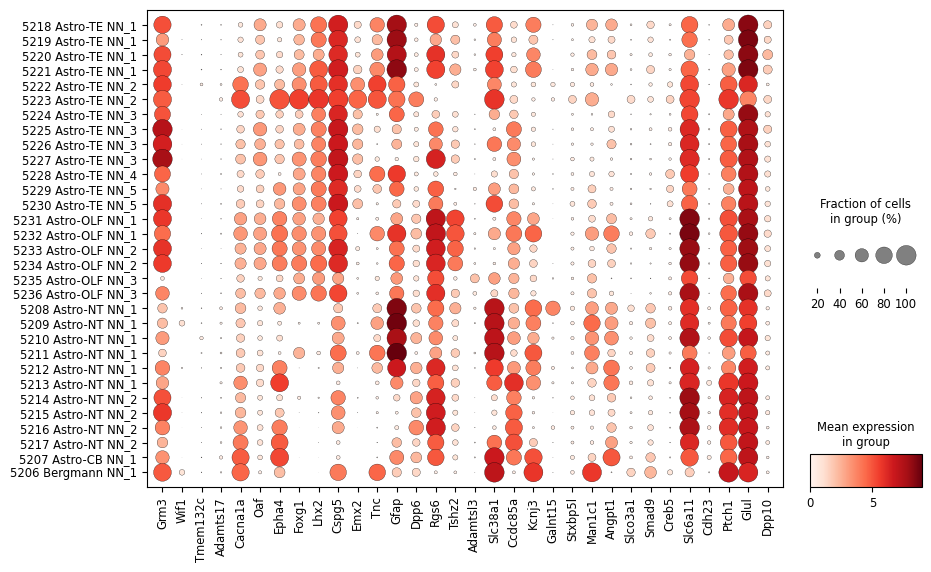

In [41]:

sc.pl.dotplot(
    adata,
    var_names=genes, 
    groupby="supertype_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
    figsize=(10,3.2),
    save="mouse_markers_supertype.pdf"
)


sc.pl.dotplot(
    adata,
    var_names=genes, 
    groupby="cluster_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
    figsize=(10,6.2),
    save="mouse_markers_cluster.pdf"
    
)

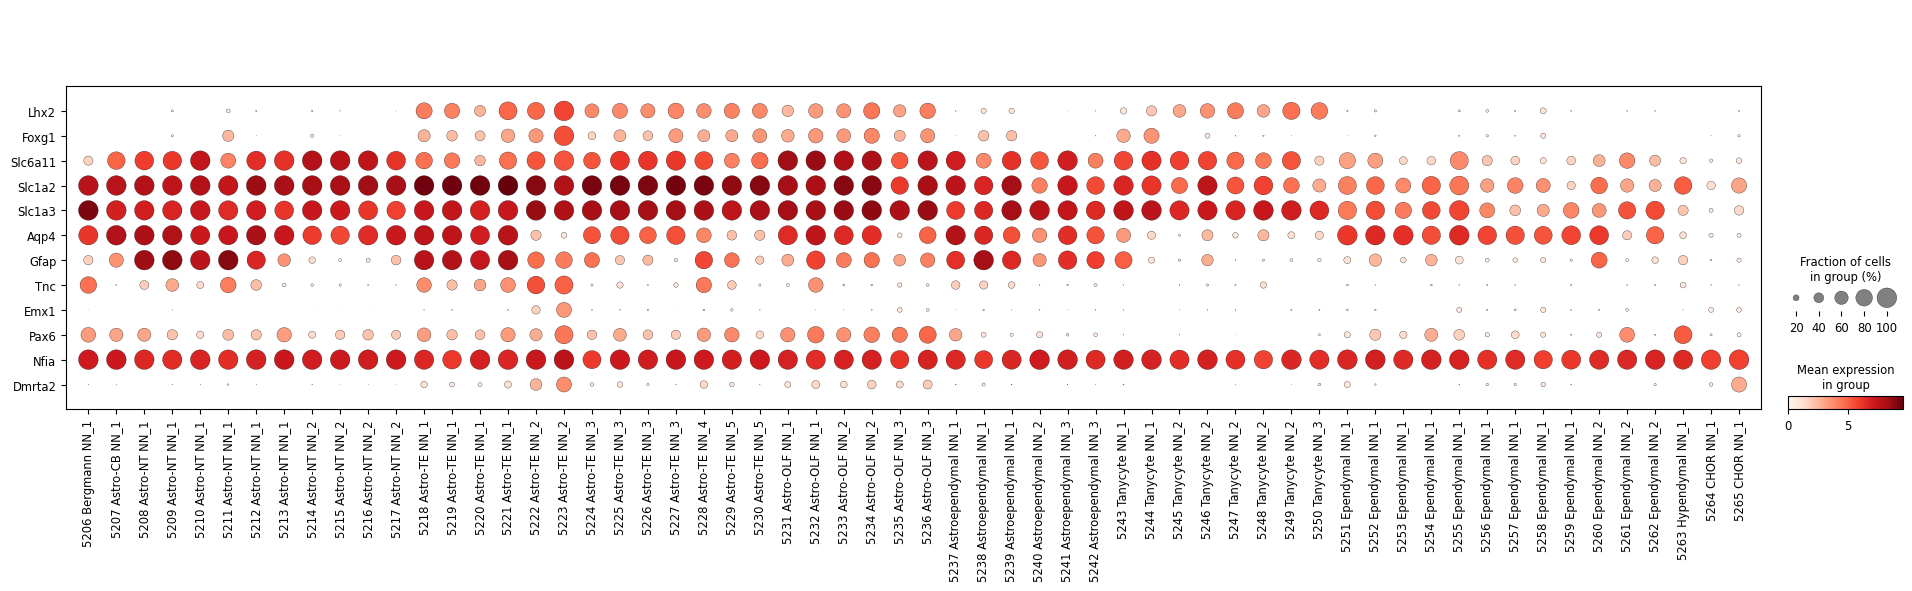

In [66]:
genes = ['Lhx2', 'Foxg1', 'Slc6a11', 'Slc1a2', 'Slc1a3', 'Aqp4', 'Gfap', 'Tnc',  'Emx1', 'Pax6', 'Nfia', 'Dmrta2']
sc.pl.dotplot(
    adata,
    var_names=genes, 
    groupby="cluster_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=True,
)

In [48]:
set(adata.obs['subclass_id_label'])

{'316 Bergmann NN',
 '317 Astro-CB NN',
 '318 Astro-NT NN',
 '319 Astro-TE NN',
 '320 Astro-OLF NN',
 '321 Astroependymal NN',
 '322 Tanycyte NN',
 '323 Ependymal NN',
 '324 Hypendymal NN',
 '325 CHOR NN'}

In [49]:
adata.obs['subclass_id_label'] = adata.obs['subclass_id_label'].astype(str)
adata6 = adata[adata.obs['subclass_id_label'].isin(['316 Bergmann NN', '317 Astro-CB NN', '318 Astro-NT NN', '319 Astro-TE NN', '320 Astro-OLF NN', '321 Astroependymal NN'])].copy() 

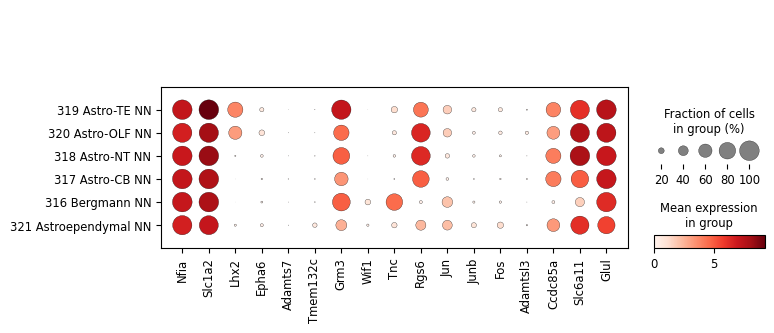

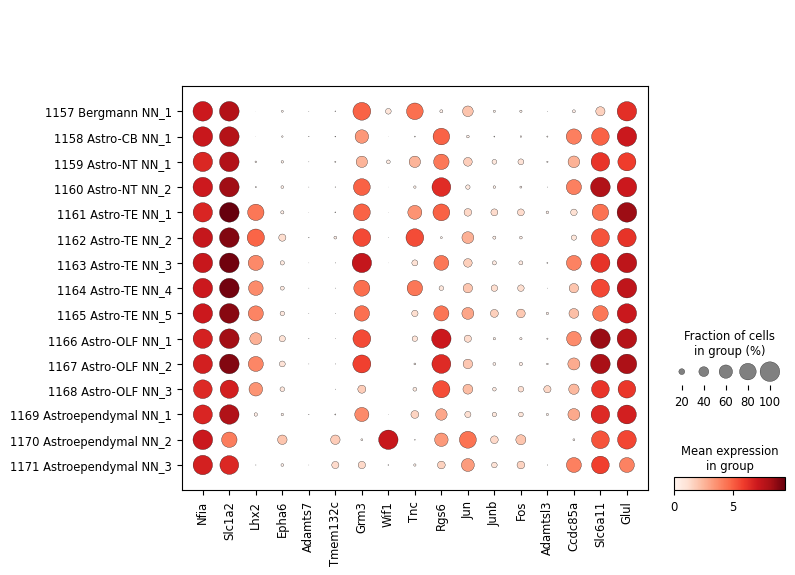

In [59]:
genes = ['Nfia', 'Slc1a2', 'Lhx2', 'Epha6', 'Adamts7', 'Tmem132c', 'Grm3', 'Wif1', 'Tnc', 'Rgs6', 'Jun', 'Junb', 'Fos', 'Adamtsl3', 'Ccdc85a', 'Slc6a11', 'Glul'] # 'Adgrv1', 'Aqp4', 'Slc1a3'

ordered_labels = ['319 Astro-TE NN', '320 Astro-OLF NN', '318 Astro-NT NN', '317 Astro-CB NN', '316 Bergmann NN', '321 Astroependymal NN']
adata6.obs["subclass_id_label"] = pd.Categorical(
    adata6.obs["subclass_id_label"],
    categories=ordered_labels,
    ordered=True
)

sc.pl.dotplot(
    adata6,
    var_names=genes, 
    groupby="subclass_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

sc.pl.dotplot(
    adata6,
    var_names=genes, 
    groupby="supertype_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

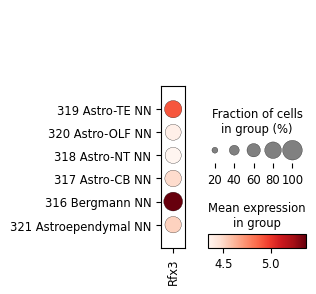

In [60]:
genes = ['Rfx3'] # 'Adgrv1', 'Aqp4', 'Slc1a3'

ordered_labels = ['319 Astro-TE NN', '320 Astro-OLF NN', '318 Astro-NT NN', '317 Astro-CB NN', '316 Bergmann NN', '321 Astroependymal NN']
adata6.obs["subclass_id_label"] = pd.Categorical(
    adata6.obs["subclass_id_label"],
    categories=ordered_labels,
    ordered=True
)

sc.pl.dotplot(
    adata6,
    var_names=genes, 
    groupby="subclass_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)


In [21]:
## cluster_id_label #anatomical_annotation (Yao et al, 2023 Nature - Supp_Table 7)

 # '5208 Astro-NT NN_1',  HB CB pia (drop)
 # '5209 Astro-NT NN_1',  MB HB pia (keep)
 # '5210 Astro-NT NN_1',  non-TE pia ventricle (keep) #no cells from our human BG mapped against this cluster. -> then, drop.
 # '5211 Astro-NT NN_1',  pia ve scattered (drop)
 # '5212 Astro-NT NN_1',  MB HB pia; ILA (keep)
 # '5213 Astro-NT NN_1',  DCO; ILA (drop - hindbrain_medulla) #many WM clusters mapped against this...
 # '5214 Astro-NT NN_2',  PAL TH HY MB (keep) ~ our exSTRd?
 # '5215 Astro-NT NN_2',  TH (keep for now) ~ STH like?
 # '5216 Astro-NT NN_2',  MY P MB (keep for now)
 # '5217 Astro-NT NN_2',  CBN VCO DCO (drop - CB and hindbrain only)
 # '5218 Astro-TE NN_1',  CTX pia sparse (drop - only CTX pia and sparse)
 # '5219 Astro-TE NN_1',  pia and fiber tract & may clean up more (keep - TE ILA; also highlighted in paper)
 # '5220 Astro-TE NN_1',  CTX pia sparse (drop)
 # '5221 Astro-TE NN_1',  CTX pia sparse (drop)
 # '5222 Astro-TE NN_2',  DG RGL-like(keep as contrast so that we cover all the supertypes)
 # '5223 Astro-TE NN_2',  DG cycling(drop -HIP)
 # '5224 Astro-TE NN_3',  enriched in LSX, HIP, DP-TT & may clean up more (drop)
 # '5225 Astro-TE NN_3',  Isocortex, OLF (keep as CTX GM contrast)
 # '5226 Astro-TE NN_3',  LSX and midline (keep - LSX belongs to STR in mice)
 # '5227 Astro-TE NN_3',  STRd (keep)
 # '5228 Astro-TE NN_4',  HIP/CTXsp (keep as contrast)
 # '5229 Astro-TE NN_5',  SVZ STRd AON (keep) RMS
 # '5230 Astro-TE NN_5'   SVZ STRd me;SVZ RGL-like (keep) RMS

rename_dict = {
    '5209 Astro-NT NN_1':  '5209_MB HB pia',
    '5210 Astro-NT NN_1':  '5210_nonTE pia ventricle',
    '5212 Astro-NT NN_1': '5212_MB HB pia-ILA',
    '5214 Astro-NT NN_2': '5214_PAL TH HY MB', 
    '5215 Astro-NT NN_2': '5215_TH',
    '5216 Astro-NT NN_2': '5216_MY P MB',
    '5219 Astro-TE NN_1': '5219_PIA fiber_tract- ILA',
    '5222 Astro-TE NN_2': '5222_DG RGL-like',
    '5225 Astro-TE NN_3': '5225_IsoCTX OLF',
    '5226 Astro-TE NN_3': '5226_LSX midline',
    '5227 Astro-TE NN_3': '5227_STRd',
    '5228 Astro-TE NN_4': '5228_HIP CTXsp',
    '5229 Astro-TE NN_5': '5229_SVZ STRd AON',
    '5230 Astro-TE NN_5': '5230_SVZ STRd me',
}

adata2.obs['cluster_TypeNotes'] = adata2.obs['cluster_id_label'].map(rename_dict)

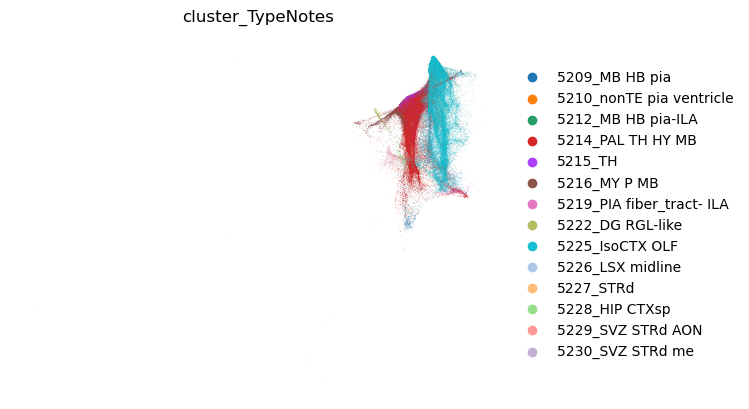

In [22]:
sc.pl.embedding(
    adata2,
    basis="EMBED3",
    color=['cluster_TypeNotes'],#'roi', 
    frameon=False,
    ncols=1
)

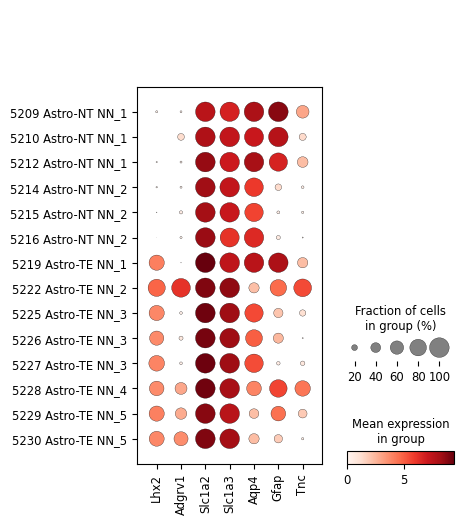

In [75]:
genes = ['Lhx2', 'Adgrv1', 'Slc1a2', 'Slc1a3', 'Aqp4', 'Gfap', 'Tnc'] 
sc.pl.dotplot(
    adata2,
    var_names=genes, 
    groupby="cluster_id_label", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

### (3) Matthew's WB Dev data - rna - human macaque mouse

In [ ]:
# The Taxonomy levels are "Neighborhood, Division, Initial_Class_markers, Initial_Class_markers_level_2."

In [2]:
mat_dev = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/V1Evo/for_cellxgene.h5ad")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/V1Evo/for_cellxgene.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
mat_dev 

In [ ]:
set(mat_dev.obs["Division"])

In [ ]:
division_order = [
    # Early embryonic / diencephalon-midbrain
    "NPC", "TEv",  "TEd",  "DEd", "MEd",  "DE-ME_GABA",  "DMR_GABA", "DMR_Glut", "Hypo_Glut",
    # Midbrain / progenitors
     "Motor", 
    # Telencephalic progenitors
    "PEv", "RE_GABA", "RL_Glut",
    # Later differentiation
    "Sensory", 
    'Astro', 'Oligo', "MG", 'GPC', 'Ependy', "Mesenchyme",'Vascular', 'Choroid','Immune',
]
mat_dev.obs["Division"] = pd.Categorical(mat_dev.obs["Division"], categories=division_order, ordered=True)

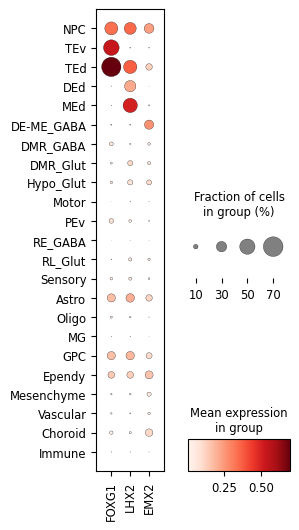

In [8]:
genelist1 = ['FOXG1','LHX2', 'EMX2'] 

sc.pl.dotplot(
    mat_dev,
    var_names=genelist1, 
    groupby="Division", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
    figsize=(2.5,6),
    save="mat_dev_tfs_in_whole.pdf"
)

In [9]:
subset_divisions = ["NPC", "TEv",  "TEd",  "DEd", "MEd",  "DE-ME_GABA"]

mask = mat_dev.obs['Division'].astype(str).isin(subset_divisions)
adata_div = mat_dev[mask].copy()

# Fix the category order inside the subset for consistent plotting
adata_div.obs['Division'] = pd.Categorical(
    adata_div.obs['Division'].astype(str),
    categories=subset_divisions,  # keeps the specified biological order
    ordered=True
)

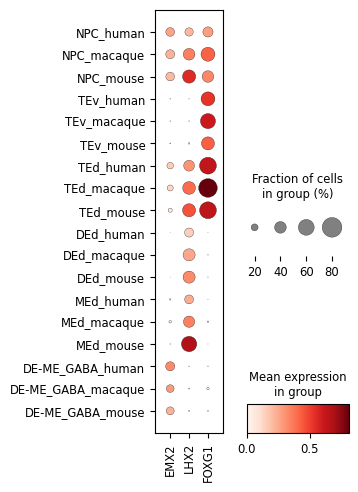

In [10]:
genelist1= ['EMX2', 'LHX2', 'FOXG1']

sc.pl.dotplot(
    adata_div,
    var_names=genelist1,
    groupby=["Division", "species"], 
    use_raw=False,
    dendrogram=False,
    standard_scale=None,
    swap_axes=False,
    figsize=(2.5,5.5),
    save="mat_dev_tfs_in_DorVentral.pdf"
)


#### focusing on Astro

In [8]:
mat_dev_astro = mat_dev[mat_dev.obs['Initial_Class_markers'].isin(['Astro-TE_IL33', 'Astro-Bergmann_GDF10', 'Astro_EDNRB', 'Astro_Rx_DST,ITPR2', 'Astro_Rx_DST,CRYAB', 
                                                                         'Progen_Astro-Bergmann_GDF10', 'Progen_Astro-Ependy_PIFO', 'Progen_Astro-OPC_EGFR', 'Progen_Astro-TE'])].copy()

order = ['Astro-TE_IL33', 'Progen_Astro-TE', 'Astro-Bergmann_GDF10', 'Progen_Astro-Bergmann_GDF10', 'Astro_EDNRB', 'Astro_Rx_DST,ITPR2', 'Astro_Rx_DST,CRYAB', 'Progen_Astro-Ependy_PIFO', 'Progen_Astro-OPC_EGFR']
mat_dev_astro.obs["Initial_Class_markers"] = pd.Categorical(mat_dev_astro.obs["Initial_Class_markers"], categories=order, ordered=True)

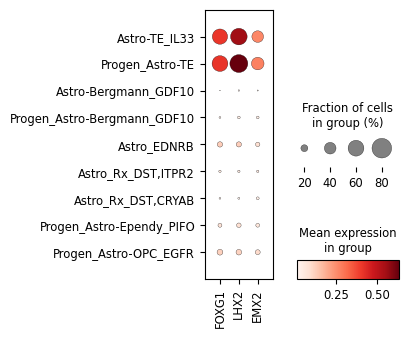

In [16]:
genelist1= ['FOXG1', 'LHX2', 'EMX2']

sc.pl.dotplot(
    mat_dev_astro,
    var_names=genelist1,
    groupby=["Initial_Class_markers"], 
    use_raw=False,
    dendrogram=False,
    standard_scale=None,
    swap_axes=False,
    figsize=(2.5,3.5),
    save="mat_dev_tfs_in_astro.pdf"
)


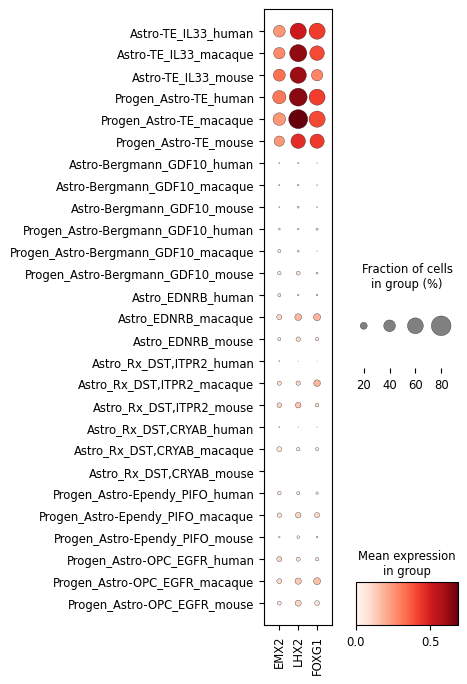

In [19]:
genelist1= ['EMX2', 'LHX2', 'FOXG1']

sc.pl.dotplot(
    mat_dev_astro,
    var_names=genelist1,
    groupby=["Initial_Class_markers", "species"], 
    use_raw=False,
    dendrogram=False,
    standard_scale=None,
    swap_axes=False,
    figsize=(2.5,8),
    save="mat_dev_tfs_in_astro_perSpecies.pdf"
)


In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def split_dots_dotplot(
    adata,
    genes,
    group_key="Initial_Class_markers",
    species_key="species",
    layer=None,
    figsize=(10, 6),
    cmap="Reds",
    species_order=None,
    species_markers=None,
    vmin=None,
    vmax=None,
    pct_threshold=0.0,
    size_scale=300.0,
    edgecolor="k",
    linewidth=0.3,
    offset_span=0.40,
):
    """
    Split-dots dotplot where:
      - color encodes mean expression,
      - size encodes fraction of expressing cells (> pct_threshold),
      - marker shape encodes species.

    Parameters
    ----------
    adata : AnnData
    genes : list[str]
        Genes to plot (columns must exist in adata.var_names).
    group_key : str
        Grouping column in adata.obs (e.g., cell types).
    species_key : str
        Species column in adata.obs (e.g., "Human", "Macaque", "Marmoset").
    layer : str | None
        Use adata.layers[layer] if provided; otherwise use adata.X.
    figsize : tuple
        Matplotlib figure size.
    cmap : str
        Colormap name for mean expression.
    species_order : list[str] | None
        Explicit order of species (left → right within each cell).
    species_markers : dict[str,str] | None
        Mapping from species name to matplotlib marker, e.g. {"Human":"o","Macaque":"s","Mouse":"^"}.
    vmin, vmax : float | None
        Color normalization bounds for mean expression. If None, use data min/max.
    pct_threshold : float
        Expression threshold for counting a cell as "expressing" (default 0).
    size_scale : float
        Multiplier for dot size; final size = frac * size_scale.
    edgecolor : str
        Edge color for markers.
    linewidth : float
        Edge line width for markers.
    offset_span : float
        Total horizontal spread used to separate species within each grid cell.
    """
    # --------------- Extract only requested genes to save memory ---------------
    gene_locs = [adata.var_names.get_loc(g) for g in genes]
    mat = adata.layers[layer] if layer else adata.X
    subX = mat[:, gene_locs]
    subX = subX.A if hasattr(subX, "A") else subX  # handle sparse
    expr_df = pd.DataFrame(subX, index=adata.obs_names, columns=genes)

    # --------------- Aggregate mean and fraction per (group, species, gene) ---------------
    obs_meta = adata.obs[[group_key, species_key]].copy()
    df_long = []
    for g in genes:
        tmp = expr_df[[g]].join(obs_meta)
        mean_exp = tmp.groupby([group_key, species_key])[g].mean()
        frac_exp = tmp.groupby([group_key, species_key])[g].apply(lambda x: (x > pct_threshold).mean())
        out = pd.DataFrame({"mean": mean_exp, "frac": frac_exp}).reset_index()
        out["gene"] = g
        df_long.append(out)
    df = pd.concat(df_long, ignore_index=True)

    # --------------- Orders and positions ---------------
    groups = list(df[group_key].unique())
    if species_order is None:
        species = list(df[species_key].unique())
    else:
        species = [sp for sp in species_order if sp in df[species_key].unique()]

    x_pos = {g: i for i, g in enumerate(genes)}
    y_pos = {c: i for i, c in enumerate(groups)}

    # --------------- Marker shapes for species ---------------
    # Default mapping if not provided. You can override via species_markers arg.
    default_cycle = ["o", "s", "^", "D", "P", "X", "*", "v", "<", ">"]
    auto_map = {}
    # Heuristics for common names
    for sp in species:
        sl = str(sp).lower()
        if "human" in sl:
            auto_map[sp] = "o"
        elif "macaque" in sl:
            auto_map[sp] = "s"
        elif "marmoset" in sl or "mouse" in sl or "mus" in sl:
            auto_map[sp] = "^"
        else:
            # assign from cycle (avoid duplicates)
            for mk in default_cycle:
                if mk not in auto_map.values():
                    auto_map[sp] = mk
                    break
    if species_markers is not None:
        auto_map.update({k: species_markers[k] for k in species_markers if k in species})
    markers = auto_map  # final mapping

    # --------------- Color normalization ---------------
    vmin = df["mean"].min() if vmin is None else vmin
    vmax = df["mean"].max() if vmax is None else vmax
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = mpl.cm.get_cmap(cmap)

    # --------------- Offsets for side-by-side species separation ---------------
    nsp = max(1, len(species))
    if nsp == 1:
        offsets = np.array([0.0])
    else:
        offsets = np.linspace(-offset_span / 2.0, offset_span / 2.0, nsp)

    # --------------- Plot ---------------
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in df.iterrows():
        gx, gy = x_pos[row["gene"]], y_pos[row[group_key]]
        sp = row[species_key]
        if sp not in species:
            continue  # skip if not in desired order
        sid = species.index(sp)
        dx = offsets[sid]

        size = max(0.0, float(row["frac"])) * size_scale
        color = cmap_obj(norm(row["mean"]))
        ax.scatter(
            gx + dx, gy,
            s=size,
            c=[color],
            marker=markers[sp],
            edgecolors=edgecolor,
            linewidth=linewidth
        )

    # --------------- Axes formatting ---------------
    ax.set_xticks(list(x_pos.values()))
    ax.set_xticklabels(list(x_pos.keys()), rotation=45, ha="right")
    ax.set_yticks(list(y_pos.values()))
    ax.set_yticklabels(list(y_pos.keys()))
    ax.set_xlim(-0.6, len(genes) - 0.4)
    ax.set_ylim(-0.6, len(groups) - 0.4)
    ax.invert_yaxis()  # optional: to match typical dotplot top-down ordering

    # --------------- Legends ---------------
    # Species legend (markers)
    handles_species = []
    for sp in species:
        h = ax.scatter([], [], s=80, c="gray", marker=markers[sp],
                       edgecolors=edgecolor, linewidth=linewidth, label=sp)
        handles_species.append(h)
    leg1 = ax.legend(handles=handles_species, title="Species",
                     bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    ax.add_artist(leg1)

    # Size legend (fractions)
    for_sizes = [0.25, 0.5, 0.75]
    handles_size = [ax.scatter([], [], s=s * size_scale, c="white", edgecolors=edgecolor, linewidth=linewidth)
                    for s in for_sizes]
    labels_size = [f"{int(s*100)}%" for s in for_sizes]
    leg2 = ax.legend(handles=handles_size, labels=labels_size, title="Fraction > threshold",
                     bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0.)
    ax.add_artist(leg2)

    # Colorbar for mean expression
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Mean expression")

    ax.set_title("Split-dots Dotplot\n(size = fraction expressing, color = mean expression, marker = species)")
    plt.tight_layout()
    plt.show()




genes = ["FOXG1", "LHX2", "EMX2"]

# （circle=Human，square=Macaque，triangle=Mouse）
split_dots_dotplot(
    mat_dev_astro, genes,
    group_key="Initial_Class_markers",
    species_key="species",
    layer=None,                 # or "UMIs"
    species_order=["human", "macaque", "mouse"],   
    species_markers={"human":"o", "macaque":"s", "mouse":"^"},
    pct_threshold=0.0,          # >0 counted as expressing
    size_scale=300,
    cmap="Reds",
    figsize=(10, 6)
)


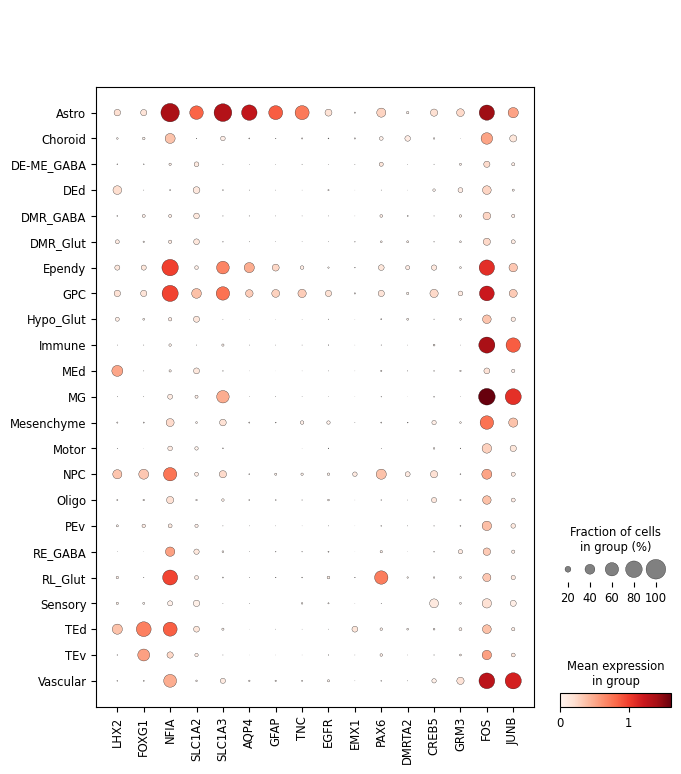

In [48]:
genelist1 = ['LHX2','FOXG1', 'NFIA', 'SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC', 'EGFR', 'EMX1', 'PAX6', 'DMRTA2', 'CREB5', 'GRM3', 'FOS', 'JUNB'] #'epha6',

sc.pl.dotplot(
    mat_dev,
    var_names=genelist1, 
    groupby="Division", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
 #   figsize=(10,10),
    #save="dotplot_AstrofilteredTFs_in_HMBAhumanBG.pdf"
)

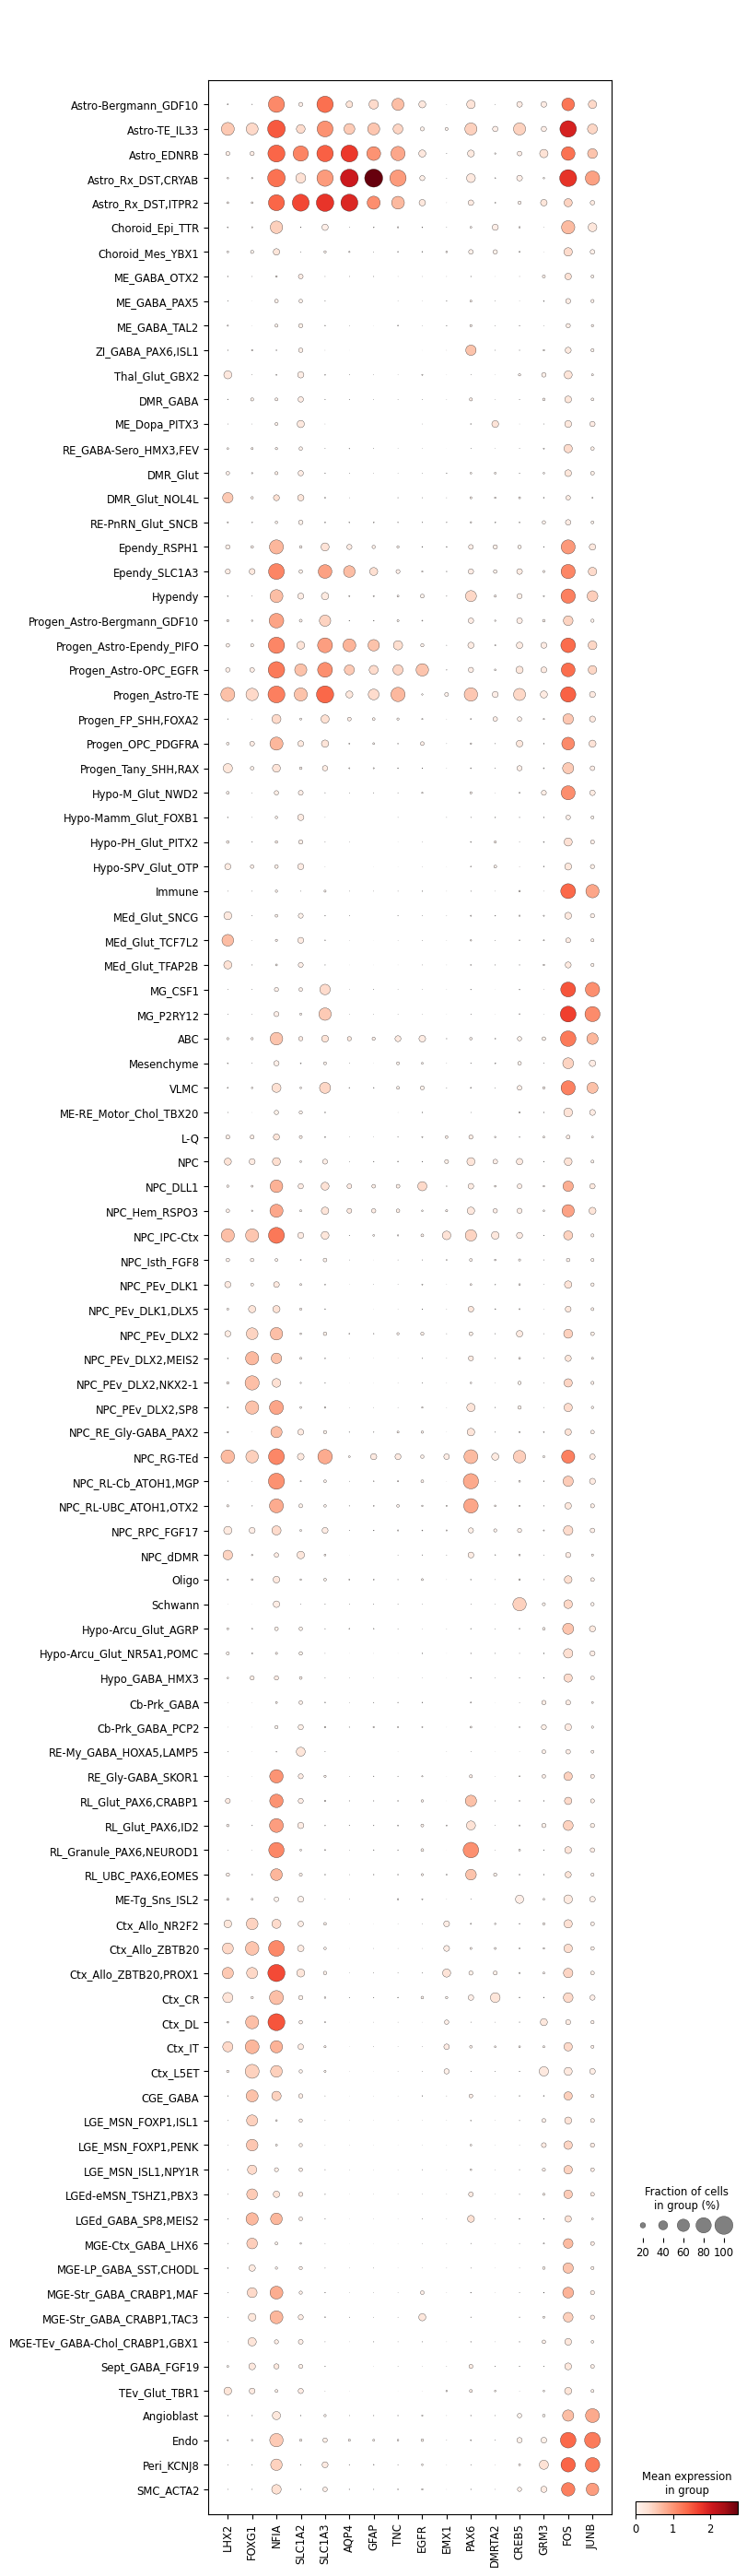

In [49]:
genelist1 = ['LHX2','FOXG1', 'NFIA', 'SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC', 'EGFR', 'EMX1', 'PAX6', 'DMRTA2', 'CREB5', 'GRM3', 'FOS', 'JUNB'] #'epha6',

sc.pl.dotplot(
    mat_dev,
    var_names=genelist1, 
    groupby="Initial_Class_markers", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
 #   figsize=(10,10),
    #save="dotplot_AstrofilteredTFs_in_HMBAhumanBG.pdf"
)

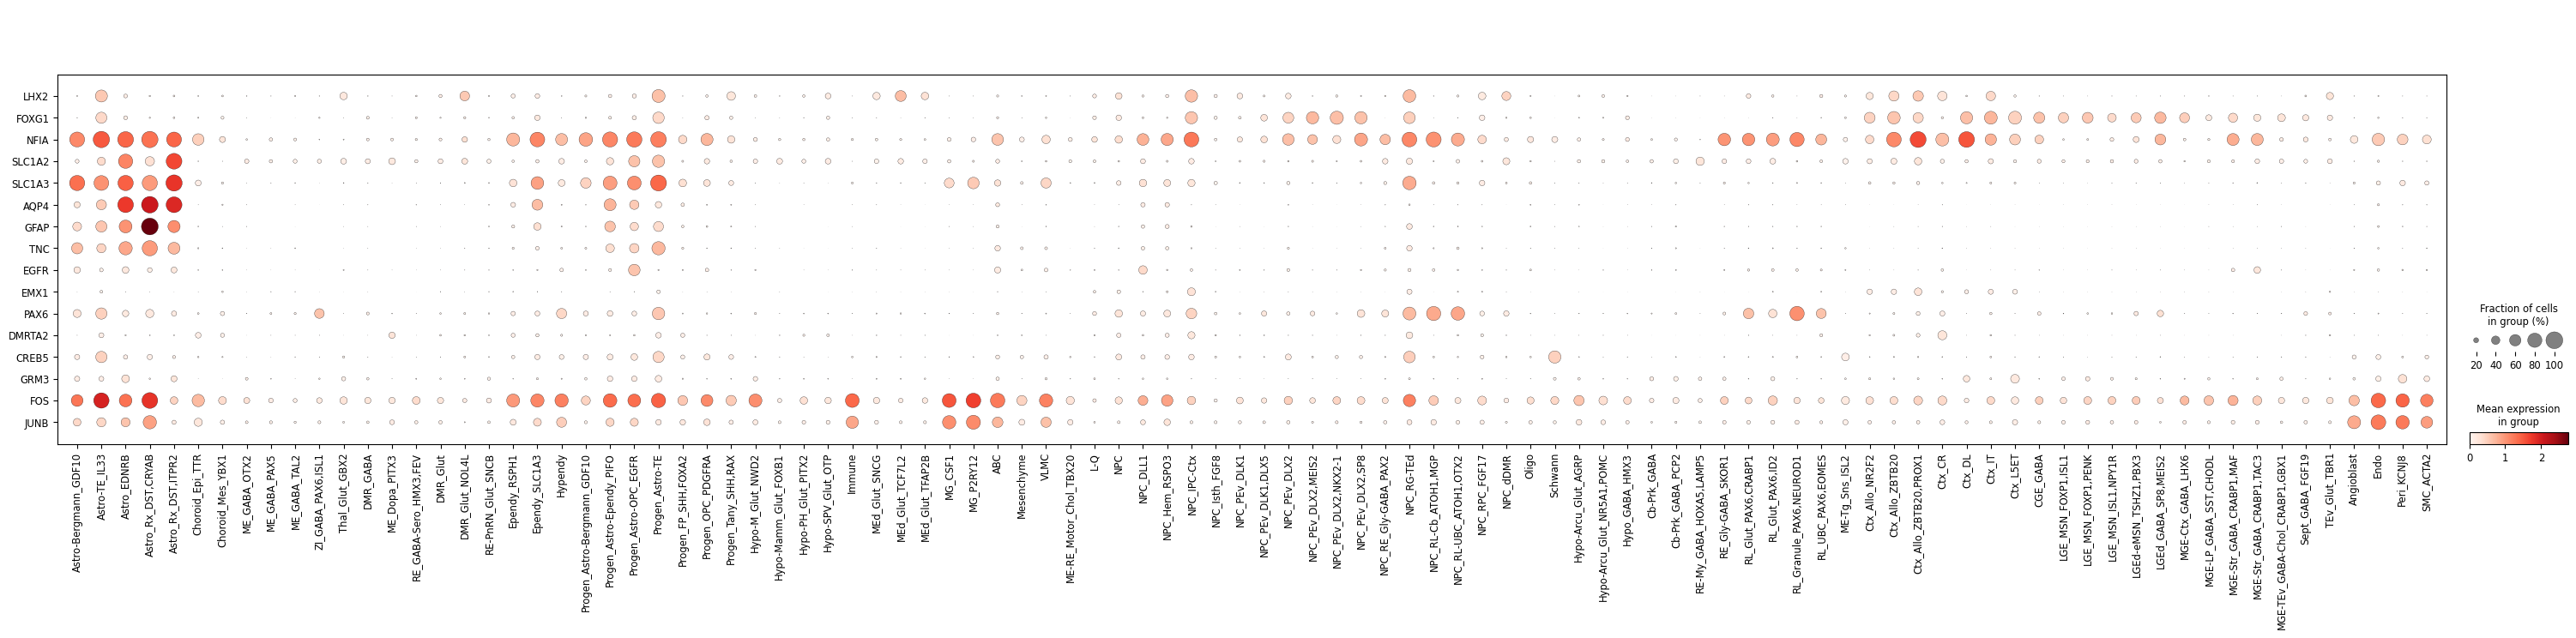

In [50]:
genelist1 = ['LHX2','FOXG1', 'NFIA', 'SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC', 'EGFR', 'EMX1', 'PAX6', 'DMRTA2', 'CREB5', 'GRM3', 'FOS', 'JUNB'] #'epha6',

sc.pl.dotplot(
    mat_dev,
    var_names=genelist1, 
    groupby="Initial_Class_markers", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=True,
 #   figsize=(10,10),
    #save="dotplot_AstrofilteredTFs_in_HMBAhumanBG.pdf"
)

In [52]:
print(set(mat_dev.obs['Neighborhood']))
print(set(mat_dev.obs['Division']))
print(set(mat_dev.obs['Initial_Class_markers']))

{'P', 'Neighbor', 'T', 'DMR', 'NN', 'ExoNN'}
{'TEv', 'Ependy', 'Choroid', 'Sensory', 'DMR_Glut', 'Vascular', 'MEd', 'MG', 'Mesenchyme', 'GPC', 'TEd', 'RL_Glut', 'DMR_GABA', 'Immune', 'NPC', 'Astro', 'Motor', 'Hypo_Glut', 'Oligo', 'RE_GABA', 'PEv', 'DE-ME_GABA', 'DEd'}
{'Progen_Astro-Bergmann_GDF10', 'Astro-TE_IL33', 'Ctx_Allo_ZBTB20,PROX1', 'Hypo-M_Glut_NWD2', 'MGE-Str_GABA_CRABP1,TAC3', 'NPC_Isth_FGF8', 'Ctx_Allo_NR2F2', 'NPC_dDMR', 'ME_GABA_PAX5', 'ME-RE_Motor_Chol_TBX20', 'Ctx_CR', 'MGE-Ctx_GABA_LHX6', 'Astro_EDNRB', 'DMR_Glut', 'NPC_RG-TEd', 'RL_Glut_PAX6,ID2', 'ME_GABA_OTX2', 'Thal_Glut_GBX2', 'ME-Tg_Sns_ISL2', 'L-Q', 'NPC_IPC-Ctx', 'NPC_DLL1', 'NPC_PEv_DLK1', 'Oligo', 'RL_Glut_PAX6,CRABP1', 'MEd_Glut_TFAP2B', 'Hypo-Arcu_Glut_AGRP', 'MG_CSF1', 'Progen_Astro-Ependy_PIFO', 'RL_Granule_PAX6,NEUROD1', 'Hypo-PH_Glut_PITX2', 'Astro_Rx_DST,CRYAB', 'Angioblast', 'ME_Dopa_PITX3', 'Cb-Prk_GABA_PCP2', 'Hypendy', 'ME_GABA_TAL2', 'VLMC', 'Choroid_Mes_YBX1', 'NPC_RE_Gly-GABA_PAX2', 'Choroid_Epi

In [27]:
mat_dev_nn = mat_dev[mat_dev.obs['Neighborhood'].isin(["NN"])].copy()

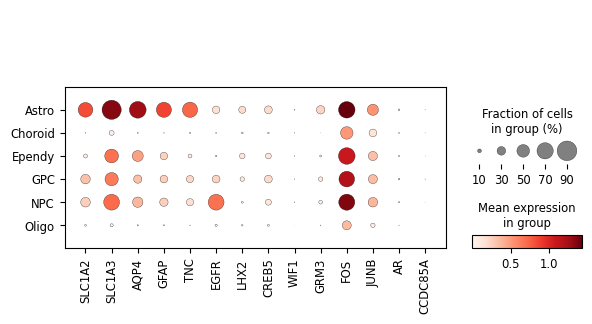

In [28]:
genelist1 = ['SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC', 'EGFR', 'LHX2', 'CREB5', 'WIF1', 'GRM3', 'FOS', 'JUNB', 'AR', 'CCDC85A'] #'epha6',

sc.pl.dotplot(
    mat_dev_nn,
    var_names=genelist1, 
    groupby="Division", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
 #   figsize=(10,10),
    #save="dotplot_AstrofilteredTFs_in_HMBAhumanBG.pdf"
)

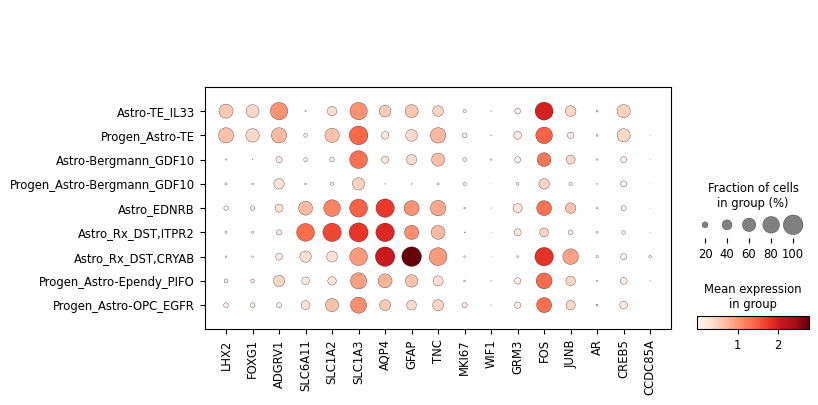

In [72]:
genelist1 = ['LHX2', 'FOXG1', 'ADGRV1', 'SLC6A11', 'SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC', 'MKI67', 'WIF1', 'GRM3', 'FOS', 'JUNB', 'AR', 'CREB5', 'CCDC85A'] #'epha6',

sc.pl.dotplot(
    mat_dev_astro,
    var_names=genelist1, 
    groupby="Initial_Class_markers", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

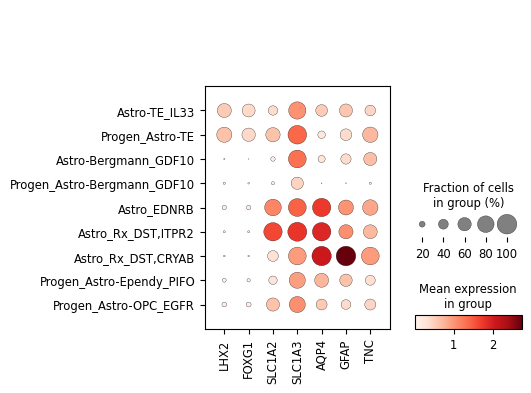

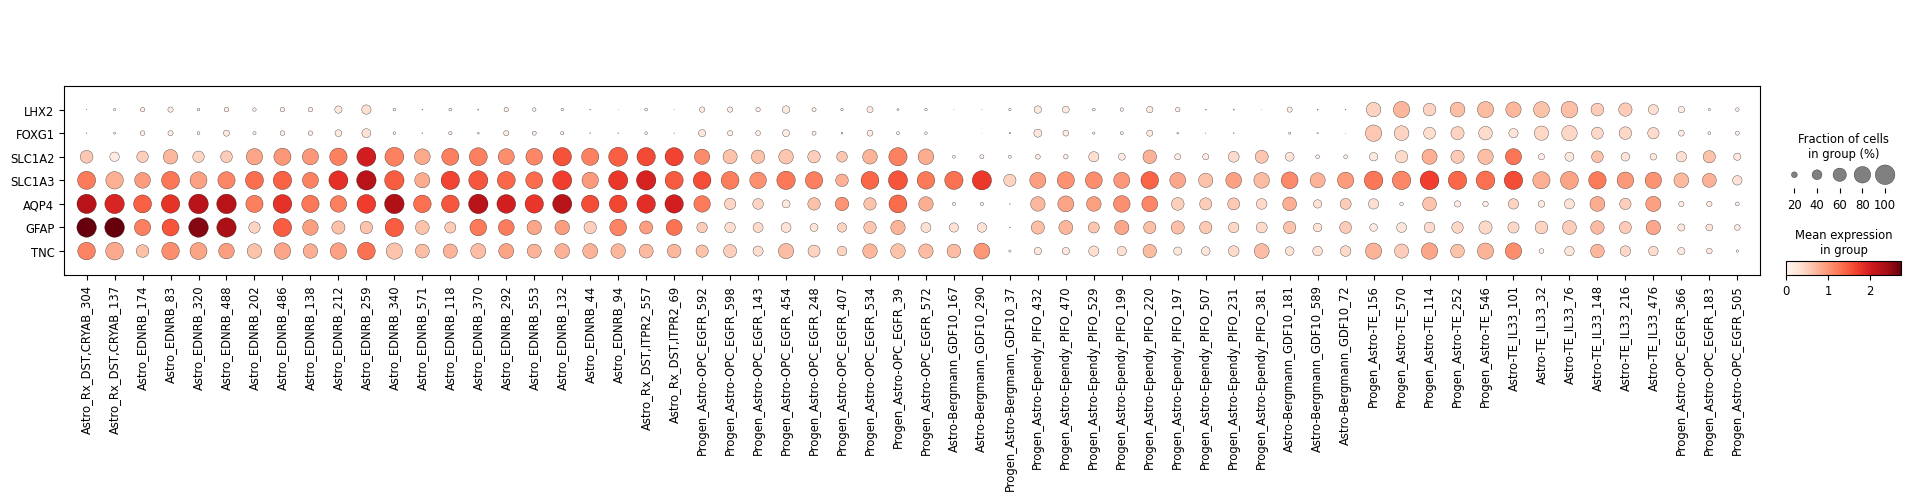

In [57]:
genelist1 = ['LHX2', 'FOXG1', 'SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC'] #'epha6',

sc.pl.dotplot(
    mat_dev_astro,
    var_names=genelist1, 
    groupby="Initial_Class_markers", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

sc.pl.dotplot(
    mat_dev_astro,
    var_names=genelist1, 
    groupby="Initial_Class_markers_level_2", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=True,
)

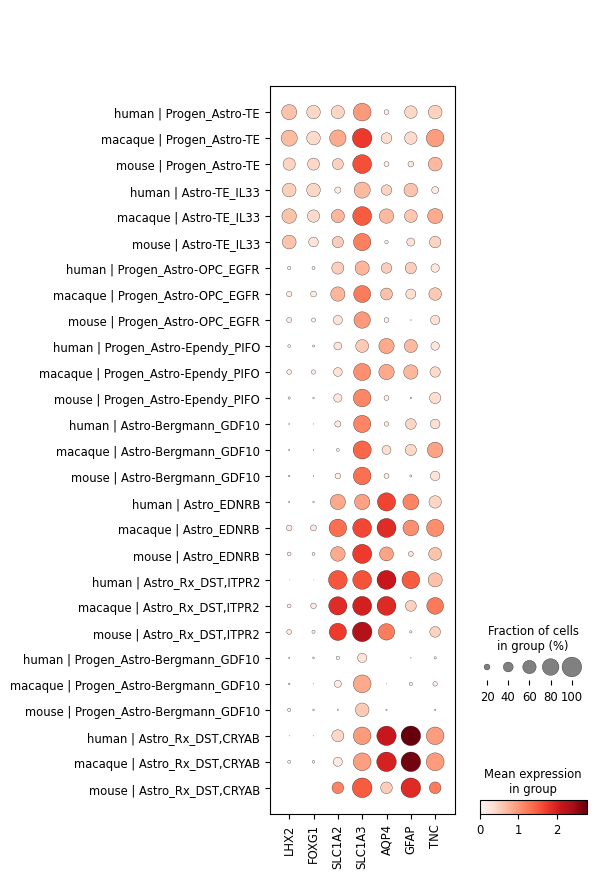

In [58]:
types = mat_dev_astro.obs["Initial_Class_markers"].unique()
species_order = ["human", "macaque", "mouse"]

mat_dev_astro.obs["species_type"] = (
    mat_dev_astro.obs["species"].astype(str) 
    + " | " + 
    mat_dev_astro.obs["Initial_Class_markers"].astype(str)
)

order = [f"{sp} | {tp}" for tp in types for sp in species_order]
mat_dev_astro.obs["species_type"] = pd.Categorical(mat_dev_astro.obs["species_type"], categories=order, ordered=True)

sc.pl.dotplot(
    mat_dev_astro,
    var_names=genelist1, 
    groupby="species_type", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)


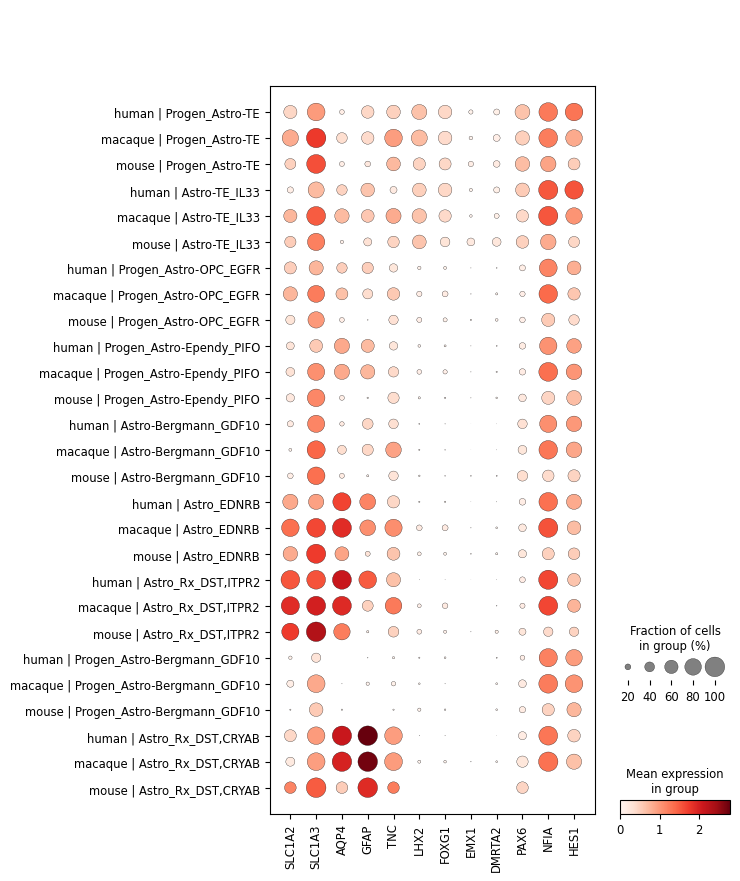

In [59]:
genes = ['SLC1A2', 'SLC1A3', 'AQP4', 'GFAP', 'TNC', 'LHX2', 'FOXG1', 'EMX1', 'DMRTA2', 'PAX6', 'NFIA', 'HES1']
sc.pl.dotplot(
    mat_dev_astro,
    var_names=genes, 
    groupby="species_type", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

In [60]:
mat_dev_astro_TE = mat_dev_astro[mat_dev_astro.obs['Initial_Class_markers'].isin(["Astro-TE_IL33", "Progen_Astro-TE"])].copy()
mat_dev_astro_TE

AnnData object with n_obs × n_vars = 53893 × 16738
    obs: 'phase', 'species', 'region', 'general_region', 'level_1', 'Initial_Class_markers_level_2', 'clipped_psi_2', 'timepoint', 'species_dataset_name', 'log10_n_counts', 'Neighborhood', 'Initial_Class', 'level_2', 'Division', 'Initial_Class_markers', 'abc_subclass_markercor', 'species_type'
    uns: 'Division_colors', 'Division_colors_dict', 'Initial_Class_colors', 'Initial_Class_colors_dict', 'Initial_Class_markers_colors', 'Initial_Class_markers_colors_dict', 'Initial_Class_markers_level_2_colors', 'Initial_Class_markers_level_2_colors_dict', 'Neighborhood_colors', 'Neighborhood_colors_dict', '_scvi_manager_uuid', '_scvi_uuid', 'abc_subclass_markercor_colors', 'batch_name_colors', 'dendrogram_Initial_Class_markers_level_2', 'dendrogram_level_2', 'general_region_color_dict', 'general_region_colors', 'leiden', 'level_1_colors', 'level_1_colors_dict', 'level_2_colors', 'level_2_colors_dict', 'param_store', 'pca', 'phase_color_dict', 

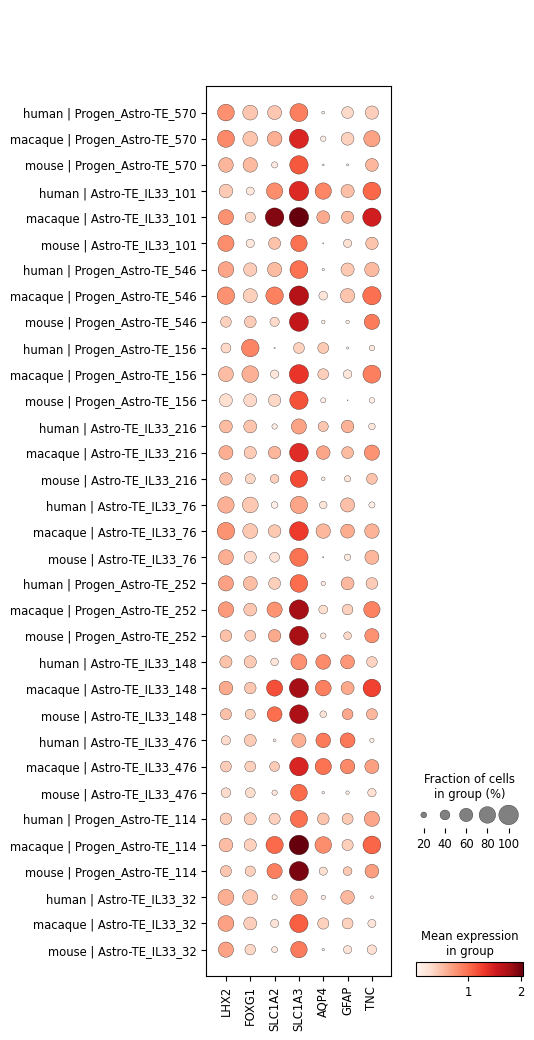

In [61]:
types = mat_dev_astro_TE.obs["Initial_Class_markers_level_2"].unique()
species_order = ["human", "macaque", "mouse"]

mat_dev_astro_TE.obs["species_ClassL2"] = (
    mat_dev_astro_TE.obs["species"].astype(str) 
    + " | " + 
    mat_dev_astro_TE.obs["Initial_Class_markers_level_2"].astype(str)
)

order = [f"{sp} | {tp}" for tp in types for sp in species_order]
mat_dev_astro_TE.obs["species_ClassL2"] = pd.Categorical(mat_dev_astro_TE.obs["species_ClassL2"], categories=order, ordered=True)

sc.pl.dotplot(
    mat_dev_astro_TE,
    var_names=genelist1, 
    groupby="species_ClassL2", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)


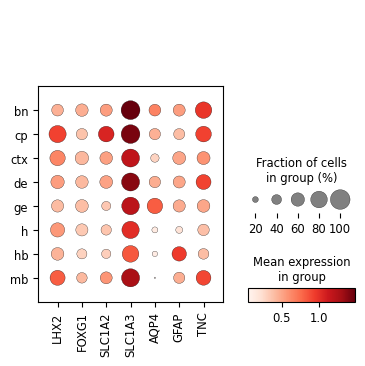

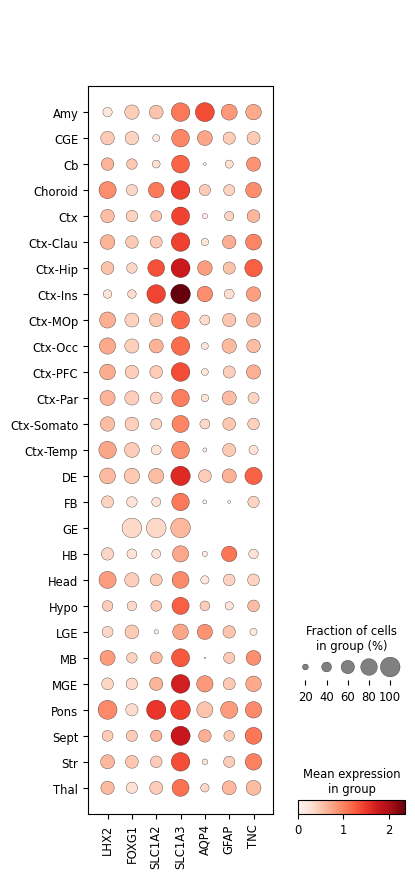

In [62]:
sc.pl.dotplot(
    mat_dev_astro_TE,
    var_names=genelist1, 
    groupby="general_region", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

sc.pl.dotplot(
    mat_dev_astro_TE,
    var_names=genelist1, 
    groupby="region", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)

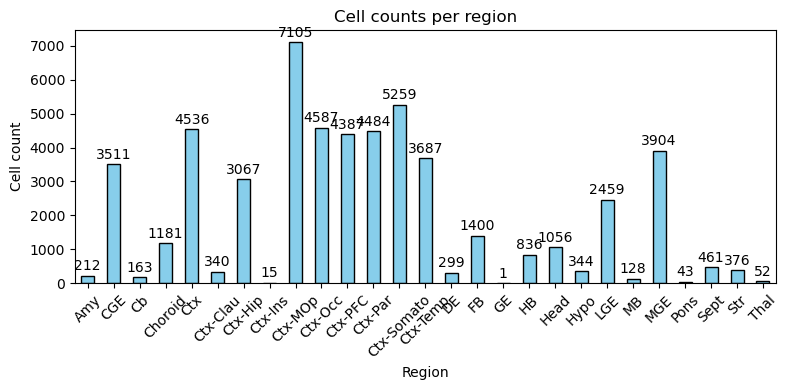

In [63]:
region_counts = mat_dev_astro_TE.obs["region"].value_counts().sort_index()
#general_region_counts = mat_dev_astro_TE.obs["general_region"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4))

region_counts.plot(
    kind="bar",
    ax=ax,
    stacked=True,    
    color="skyblue",
    edgecolor="black"
)


ax.set_ylabel("Cell count")
ax.set_xlabel("Region")
ax.set_title("Cell counts per region")
ax.tick_params(axis='x', rotation=45)


for i, count in enumerate(region_counts):
    ax.text(i, count + max(region_counts)*0.01, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


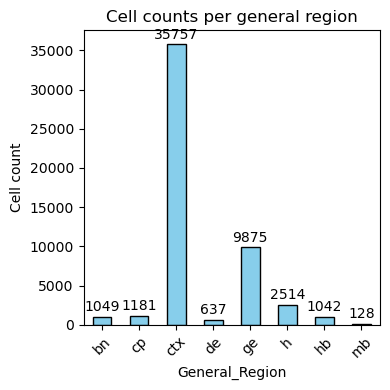

In [64]:
#region_counts = mat_dev_astro_TE.obs["region"].value_counts().sort_index()
general_region_counts = mat_dev_astro_TE.obs["general_region"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(4, 4))

general_region_counts.plot(
    kind="bar",
    ax=ax,
    stacked=True,    
    color="skyblue",
    edgecolor="black"
)


ax.set_ylabel("Cell count")
ax.set_xlabel("General_Region")
ax.set_title("Cell counts per general region")
ax.tick_params(axis='x', rotation=45)


for i, count in enumerate(general_region_counts):
    ax.text(i, count + max(general_region_counts)*0.01, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


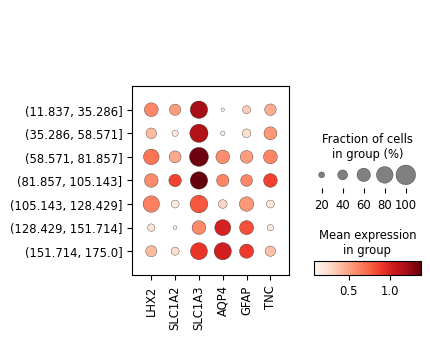

In [40]:
sc.pl.dotplot(
    mat_dev_astro_TE,
    var_names=genelist1, 
    groupby="timepoint", 
    use_raw=False,
    dendrogram=False,
    standard_scale= None,#'var',  
    swap_axes=False,
)


In [65]:
mat_dev_astro.write_h5ad(data_dir + "/Mat_dev_astro.h5ad")

### (4) Feng lab Marmoset Mouse Dev/postnatal data

In [ ]:
# WB models - DeepChicken/Mouse/Macaque/Human + LHX2 papers!

In [ ]:
## Check the TFs pattern (LHX2 first)